In [6]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

# Set a seed for reproducibility (optional)
np.random.seed(42)
random.seed(42)

# =========================================
# Possibilistic C51 Agent (Tabular)
# =========================================
class PossibilisticC51Agent:
    def __init__(self, n_states, n_actions, atoms, gamma=0.9, sigma=0.5, alpha=0.1, epsilon=0.05):
        """
        n_states: number of discrete states
        n_actions: number of discrete actions
        atoms: a numpy array of return atoms (e.g., np.linspace(0, 10, 11))
        gamma: discount factor
        sigma: parameter for the Gaussian likelihood
        alpha: learning rate for the possibility update
        epsilon: probability of taking a random action (epsilon-greedy)
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.atoms = atoms
        self.n_atoms = len(atoms)
        self.gamma = gamma
        self.sigma = sigma
        self.alpha = alpha
        self.epsilon = epsilon
        
        # Possibility table: (state, action) -> possibility vector over atoms
        self.possibility_table = {}
    
    def get_possibility(self, state, action):
        key = (state, action)
        if key not in self.possibility_table:
            # Initialize with uniform (uninformative) possibility: all ones
            self.possibility_table[key] = np.ones(self.n_atoms)
        return self.possibility_table[key]
    
    def set_possibility(self, state, action, possibility_vec):
        key = (state, action)
        self.possibility_table[key] = possibility_vec
    
    def likelihood(self, r, z):
        """
        Gaussian likelihood for reward r given atom z
        (omitting the normalization constant).
        """
        return np.exp(-((r - z)**2) / (2.0*self.sigma**2))
    
    def optimistic_q(self, state, action):
        """
        Q(s,a) = max_j [ atoms[j] * possibility[j] ].
        """
        poss = self.get_possibility(state, action)
        return np.max(self.atoms * poss)
    
    def select_action(self, state):
        """
        Epsilon-greedy over the optimistic Q-values.
        With probability epsilon, pick a random action;
        otherwise pick the action with the highest optimistic Q-value.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = [self.optimistic_q(state, a) for a in range(self.n_actions)]
            return np.argmax(q_values)
    
    def update(self, state, action, reward, next_state, done):
        """
        Compute the target and update the possibility distribution using an EMA.
        """
        if done:
            target = reward
        else:
            # Next state Q-values
            q_next = [self.optimistic_q(next_state, a) for a in range(self.n_actions)]
            target = reward + self.gamma * np.max(q_next)
        
        poss_old = self.get_possibility(state, action)
        # Likelihood of each atom given the target
        like = self.likelihood(target, self.atoms)
        # Normalize by sup(like)
        like_norm = like / (np.max(like) + 1e-12)
        
        # Exponential moving average update
        poss_new = (1 - self.alpha)*poss_old + self.alpha*like_norm
        # Renormalize so sup_j poss_new[j] = 1
        poss_new /= (np.max(poss_new) + 1e-12)
        
        self.set_possibility(state, action, poss_new)
    
    def get_q_value(self, state, action):
        return self.optimistic_q(state, action)


# =========================================
# Tabular Q-Learning Baseline
# =========================================
class TabularQLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=0.05):
        """
        A simple tabular Q-learning agent for baseline comparison.
        """
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Q-table
        self.q_table = np.zeros((n_states, n_actions))
    
    def select_action(self, state):
        """
        Epsilon-greedy action selection from the Q-table.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """
        Standard Q-learning update: 
          Q(s,a) <- Q(s,a) + alpha * [r + gamma*max_a' Q(s',a') - Q(s,a)]
        """
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[next_state])
        
        old_val = self.q_table[state, action]
        self.q_table[state, action] += self.alpha * (target - old_val)
    
    def get_q_value(self, state, action):
        return self.q_table[state, action]

# =========================================
# Training Loop
# =========================================
def train_agents(num_episodes=1000, max_steps=100):
    env = gym.make('FrozenLake-v1', is_slippery=False)
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Possibilistic C51 Setup
    atoms = np.linspace(0, 10, 11)
    poss_agent = PossibilisticC51Agent(
        n_states=n_states,
        n_actions=n_actions,
        atoms=atoms,
        gamma=0.9,
        sigma=0.5,
        alpha=0.1,
        epsilon=0.05
    )
    
    # Baseline Q-learning Setup
    q_agent = TabularQLearningAgent(
        n_states=n_states,
        n_actions=n_actions,
        alpha=0.1,
        gamma=0.9,
        epsilon=0.05
    )
    
    # Track total rewards per episode
    poss_rewards_per_episode = []
    q_rewards_per_episode = []
    
    for episode in range(num_episodes):
        # Possibilistic Agent
        state, _ = env.reset()
        total_reward_p = 0
        done = False
        for _ in range(max_steps):
            action = poss_agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward_p += reward
            poss_agent.update(state, action, reward, next_state, done or truncated)
            state = next_state
            if done or truncated:
                break
        poss_rewards_per_episode.append(total_reward_p)
        
        # Q-learning Agent
        state, _ = env.reset()
        total_reward_q = 0
        done = False
        for _ in range(max_steps):
            action = q_agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward_q += reward
            q_agent.update(state, action, reward, next_state, done or truncated)
            state = next_state
            if done or truncated:
                break
        q_rewards_per_episode.append(total_reward_q)
        
        # Print debug info occasionally
        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}: PossAgentReward={total_reward_p}, QAgentReward={total_reward_q}")
    
    env.close()
    return poss_agent, q_agent, poss_rewards_per_episode, q_rewards_per_episode

def test_agent(env, agent, max_steps=100):
    """
    Evaluate a given agent in the environment for one episode, returning the path and total reward.
    """
    state, _ = env.reset()
    done = False
    truncated = False
    path = [state]
    total_r = 0
    for _ in range(max_steps):
        action = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        total_r += reward
        state = next_state
        path.append(state)
        if done or truncated:
            break
    return path, total_r

# =========================================
# Main Execution
# =========================================
if __name__ == "__main__":
    num_episodes = 10000
    poss_agent, q_agent, poss_rewards, q_rewards = train_agents(num_episodes=num_episodes, max_steps=100)
    
    # Plot performance
    plt.figure(figsize=(8,4))
    plt.plot(poss_rewards, label="Possibilistic C51 Agent")
    plt.plot(q_rewards, label="Q-learning Baseline")
    plt.title("Training Rewards per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()
    
    # Test final policies
    test_env = gym.make('FrozenLake-v1', is_slippery=False)
    
    path_p, reward_p = test_agent(test_env, poss_agent)
    path_q, reward_q = test_agent(test_env, q_agent)
    
    print("\n=== Final Policy Evaluation ===")
    print(f"Possibilistic C51: Final episode reward = {reward_p}, Path = {path_p}")
    print(f"Q-learning Baseline: Final episode reward = {reward_q}, Path = {path_q}")
    
    test_env.close()


Episode 100: PossAgentReward=0.0, QAgentReward=0.0
Episode 200: PossAgentReward=0.0, QAgentReward=0.0
Episode 300: PossAgentReward=0.0, QAgentReward=0.0
Episode 400: PossAgentReward=0.0, QAgentReward=0.0
Episode 500: PossAgentReward=0.0, QAgentReward=0.0
Episode 600: PossAgentReward=0.0, QAgentReward=0.0
Episode 700: PossAgentReward=0.0, QAgentReward=0.0
Episode 800: PossAgentReward=0.0, QAgentReward=0.0
Episode 900: PossAgentReward=1.0, QAgentReward=0.0
Episode 1000: PossAgentReward=0.0, QAgentReward=0.0
Episode 1100: PossAgentReward=0.0, QAgentReward=0.0
Episode 1200: PossAgentReward=0.0, QAgentReward=0.0
Episode 1300: PossAgentReward=0.0, QAgentReward=0.0
Episode 1400: PossAgentReward=0.0, QAgentReward=0.0
Episode 1500: PossAgentReward=0.0, QAgentReward=0.0
Episode 1600: PossAgentReward=0.0, QAgentReward=0.0
Episode 1700: PossAgentReward=0.0, QAgentReward=0.0
Episode 1800: PossAgentReward=0.0, QAgentReward=0.0
Episode 1900: PossAgentReward=0.0, QAgentReward=0.0
Episode 2000: PossAge

KeyboardInterrupt: 

  0%|▍                                                                                                                           | 327/100000 [00:00<00:58, 1695.98it/s]

Episode 100/100000
Q-Learning - Avg Reward: -5.98, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.55, Success Rate: 0.00
--------------------------------------------------
Episode 200/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.69, Success Rate: 0.00
--------------------------------------------------
Episode 300/100000
Q-Learning - Avg Reward: -6.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.55, Success Rate: 0.00
--------------------------------------------------
Episode 400/100000
Q-Learning - Avg Reward: -7.01, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.81, Success Rate: 0.00
--------------------------------------------------
Episode 500/100000
Q-Learning - Avg Reward: -6.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.80, Success Rate: 0.00
--------------------------------------------------


  1%|█                                                                                                                           | 848/100000 [00:00<01:05, 1518.58it/s]

Episode 600/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.63, Success Rate: 0.00
--------------------------------------------------
Episode 700/100000
Q-Learning - Avg Reward: -6.39, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.62, Success Rate: 0.00
--------------------------------------------------
Episode 800/100000
Q-Learning - Avg Reward: -8.37, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.14, Success Rate: 0.00
--------------------------------------------------
Episode 900/100000
Q-Learning - Avg Reward: -6.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.12, Success Rate: 0.00
--------------------------------------------------


  1%|█▍                                                                                                                         | 1146/100000 [00:00<01:13, 1344.02it/s]

Episode 1000/100000
Q-Learning - Avg Reward: -6.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.52, Success Rate: 0.00
--------------------------------------------------
Episode 1100/100000
Q-Learning - Avg Reward: -6.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.91, Success Rate: 0.00
--------------------------------------------------
Episode 1200/100000
Q-Learning - Avg Reward: -7.27, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------


  2%|█▉                                                                                                                         | 1552/100000 [00:01<01:14, 1321.31it/s]

Episode 1300/100000
Q-Learning - Avg Reward: -6.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.83, Success Rate: 0.00
--------------------------------------------------
Episode 1400/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.00, Success Rate: 0.00
--------------------------------------------------
Episode 1500/100000
Q-Learning - Avg Reward: -6.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.19, Success Rate: 0.00
--------------------------------------------------


  2%|██▏                                                                                                                        | 1823/100000 [00:01<01:13, 1331.41it/s]

Episode 1600/100000
Q-Learning - Avg Reward: -6.41, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.87, Success Rate: 0.00
--------------------------------------------------
Episode 1700/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.65, Success Rate: 0.00
--------------------------------------------------
Episode 1800/100000
Q-Learning - Avg Reward: -6.36, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------


  2%|██▌                                                                                                                        | 2091/100000 [00:01<01:22, 1181.74it/s]

Episode 1900/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.90, Success Rate: 0.00
--------------------------------------------------
Episode 2000/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------
Episode 2100/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.88, Success Rate: 0.00
--------------------------------------------------


  2%|██▉                                                                                                                        | 2356/100000 [00:01<01:18, 1244.06it/s]

Episode 2200/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------
Episode 2300/100000
Q-Learning - Avg Reward: -6.37, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------
Episode 2400/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.41, Success Rate: 0.00
--------------------------------------------------


  3%|███▍                                                                                                                       | 2761/100000 [00:02<01:13, 1317.58it/s]

Episode 2500/100000
Q-Learning - Avg Reward: -6.19, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.60, Success Rate: 0.00
--------------------------------------------------
Episode 2600/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.32, Success Rate: 0.00
--------------------------------------------------
Episode 2700/100000
Q-Learning - Avg Reward: -6.42, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.88, Success Rate: 0.00
--------------------------------------------------


  3%|███▋                                                                                                                       | 3027/100000 [00:02<01:13, 1313.32it/s]

Episode 2800/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.33, Success Rate: 0.00
--------------------------------------------------
Episode 2900/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.37, Success Rate: 0.00
--------------------------------------------------
Episode 3000/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.35, Success Rate: 0.10
--------------------------------------------------


  3%|████                                                                                                                       | 3288/100000 [00:02<01:27, 1106.83it/s]

Episode 3100/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------
Episode 3200/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.84, Success Rate: 0.00
--------------------------------------------------
Episode 3300/100000
Q-Learning - Avg Reward: -6.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.90, Success Rate: 0.00
--------------------------------------------------


  4%|████▎                                                                                                                      | 3531/100000 [00:02<01:24, 1148.12it/s]

Episode 3400/100000
Q-Learning - Avg Reward: -6.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.39, Success Rate: 0.00
--------------------------------------------------
Episode 3500/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.30, Success Rate: 0.00
--------------------------------------------------
Episode 3600/100000
Q-Learning - Avg Reward: -6.17, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.02, Success Rate: 0.00
--------------------------------------------------


  4%|████▊                                                                                                                      | 3925/100000 [00:03<01:19, 1210.66it/s]

Episode 3700/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.01, Success Rate: 0.00
--------------------------------------------------
Episode 3800/100000
Q-Learning - Avg Reward: -6.17, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.86, Success Rate: 0.00
--------------------------------------------------
Episode 3900/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.69, Success Rate: 0.00
--------------------------------------------------


  4%|█████▏                                                                                                                     | 4177/100000 [00:03<01:18, 1216.45it/s]

Episode 4000/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.39, Success Rate: 0.00
--------------------------------------------------
Episode 4100/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.29, Success Rate: 0.00
--------------------------------------------------
Episode 4200/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.45, Success Rate: 0.00
--------------------------------------------------


  4%|█████▍                                                                                                                     | 4436/100000 [00:03<01:17, 1226.22it/s]

Episode 4300/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.73, Success Rate: 0.00
--------------------------------------------------
Episode 4400/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.46, Success Rate: 0.00
--------------------------------------------------
Episode 4500/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.25, Success Rate: 0.00
--------------------------------------------------


  5%|█████▉                                                                                                                     | 4818/100000 [00:03<01:17, 1228.75it/s]

Episode 4600/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.18, Success Rate: 0.00
--------------------------------------------------
Episode 4700/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------
Episode 4800/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------


  5%|██████▏                                                                                                                    | 5067/100000 [00:03<01:18, 1216.96it/s]

Episode 4900/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.64, Success Rate: 0.00
--------------------------------------------------
Episode 5000/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.32, Success Rate: 0.00
--------------------------------------------------
Episode 5100/100000
Q-Learning - Avg Reward: -6.17, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.67, Success Rate: 0.00
--------------------------------------------------


  5%|██████▌                                                                                                                    | 5323/100000 [00:04<01:17, 1218.26it/s]

Episode 5200/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.71, Success Rate: 0.00
--------------------------------------------------
Episode 5300/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 5400/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.94, Success Rate: 0.00
--------------------------------------------------


  6%|███████                                                                                                                    | 5719/100000 [00:04<01:15, 1251.04it/s]

Episode 5500/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.09, Success Rate: 0.00
--------------------------------------------------
Episode 5600/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.01, Success Rate: 0.00
--------------------------------------------------
Episode 5700/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.11, Success Rate: 0.00
--------------------------------------------------


  6%|███████▎                                                                                                                   | 5972/100000 [00:04<01:15, 1248.09it/s]

Episode 5800/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.40, Success Rate: 0.00
--------------------------------------------------
Episode 5900/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.19, Success Rate: 0.00
--------------------------------------------------
Episode 6000/100000
Q-Learning - Avg Reward: -6.14, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -10.75, Success Rate: 0.00
--------------------------------------------------


  6%|███████▊                                                                                                                   | 6361/100000 [00:05<01:14, 1259.58it/s]

Episode 6100/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.68, Success Rate: 0.00
--------------------------------------------------
Episode 6200/100000
Q-Learning - Avg Reward: -5.38, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.16, Success Rate: 0.00
--------------------------------------------------
Episode 6300/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.20, Success Rate: 0.00
--------------------------------------------------
Episode 6400/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.13, Success Rate: 0.00
--------------------------------------------------


  7%|████████▎                                                                                                                  | 6749/100000 [00:05<01:13, 1262.09it/s]

Episode 6500/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------
Episode 6600/100000
Q-Learning - Avg Reward: -6.37, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.12, Success Rate: 0.00
--------------------------------------------------
Episode 6700/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.75, Success Rate: 0.00
--------------------------------------------------
Episode 6800/100000
Q-Learning - Avg Reward: -5.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.68, Success Rate: 0.00
--------------------------------------------------


  7%|████████▊                                                                                                                  | 7114/100000 [00:05<01:20, 1160.62it/s]

Episode 6900/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.43, Success Rate: 0.00
--------------------------------------------------
Episode 7000/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------
Episode 7100/100000
Q-Learning - Avg Reward: -6.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------
Episode 7200/100000
Q-Learning - Avg Reward: -6.21, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------


  7%|█████████▏                                                                                                                 | 7483/100000 [00:05<01:19, 1170.88it/s]

Episode 7300/100000
Q-Learning - Avg Reward: -6.24, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.63, Success Rate: 0.00
--------------------------------------------------
Episode 7400/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------
Episode 7500/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.56, Success Rate: 0.00
--------------------------------------------------


  8%|█████████▋                                                                                                                 | 7872/100000 [00:06<01:14, 1241.27it/s]

Episode 7600/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.09, Success Rate: 0.00
--------------------------------------------------
Episode 7700/100000
Q-Learning - Avg Reward: -6.05, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.80, Success Rate: 0.00
--------------------------------------------------
Episode 7800/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.46, Success Rate: 0.00
--------------------------------------------------


  8%|█████████▉                                                                                                                 | 8121/100000 [00:06<01:17, 1184.93it/s]

Episode 7900/100000
Q-Learning - Avg Reward: -6.22, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------
Episode 8000/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.08, Success Rate: 0.00
--------------------------------------------------
Episode 8100/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------


  8%|██████████▎                                                                                                                | 8370/100000 [00:06<01:15, 1212.90it/s]

Episode 8200/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.45, Success Rate: 0.00
--------------------------------------------------
Episode 8300/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.34, Success Rate: 0.00
--------------------------------------------------
Episode 8400/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.57, Success Rate: 0.00
--------------------------------------------------


  9%|██████████▊                                                                                                                | 8751/100000 [00:06<01:12, 1251.87it/s]

Episode 8500/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.75, Success Rate: 0.00
--------------------------------------------------
Episode 8600/100000
Q-Learning - Avg Reward: -6.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.11, Success Rate: 0.00
--------------------------------------------------
Episode 8700/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.45, Success Rate: 0.00
--------------------------------------------------


  9%|███████████▏                                                                                                               | 9125/100000 [00:07<01:14, 1218.60it/s]

Episode 8800/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.14, Success Rate: 0.00
--------------------------------------------------
Episode 8900/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.45, Success Rate: 0.00
--------------------------------------------------
Episode 9000/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.62, Success Rate: 0.00
--------------------------------------------------
Episode 9100/100000
Q-Learning - Avg Reward: -5.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.66, Success Rate: 0.00
--------------------------------------------------


  9%|███████████▌                                                                                                               | 9385/100000 [00:07<01:12, 1252.45it/s]

Episode 9200/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.58, Success Rate: 0.00
--------------------------------------------------
Episode 9300/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.87, Success Rate: 0.00
--------------------------------------------------
Episode 9400/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.31, Success Rate: 0.00
--------------------------------------------------
Episode 9500/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------


 10%|████████████                                                                                                               | 9776/100000 [00:07<01:10, 1271.21it/s]

Episode 9600/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.34, Success Rate: 0.00
--------------------------------------------------
Episode 9700/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 9800/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.64, Success Rate: 0.00
--------------------------------------------------


 10%|████████████▏                                                                                                             | 10027/100000 [00:08<01:14, 1212.19it/s]

Episode 9900/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------
Episode 10000/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.74, Success Rate: 0.00
--------------------------------------------------
Episode 10100/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------


 10%|████████████▋                                                                                                             | 10406/100000 [00:08<01:12, 1240.30it/s]

Episode 10200/100000
Q-Learning - Avg Reward: -6.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.47, Success Rate: 0.00
--------------------------------------------------
Episode 10300/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------
Episode 10400/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.35, Success Rate: 0.00
--------------------------------------------------


 11%|█████████████                                                                                                             | 10670/100000 [00:08<01:10, 1269.82it/s]

Episode 10500/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 10600/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------
Episode 10700/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------
Episode 10800/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.76, Success Rate: 0.00
--------------------------------------------------


 11%|█████████████▌                                                                                                            | 11096/100000 [00:08<01:08, 1294.94it/s]

Episode 10900/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------
Episode 11000/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.14, Success Rate: 0.00
--------------------------------------------------
Episode 11100/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.59, Success Rate: 0.00
--------------------------------------------------


 11%|█████████████▊                                                                                                            | 11357/100000 [00:09<01:10, 1263.54it/s]

Episode 11200/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.44, Success Rate: 0.00
--------------------------------------------------
Episode 11300/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.23, Success Rate: 0.00
--------------------------------------------------
Episode 11400/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.06, Success Rate: 0.00
--------------------------------------------------


 12%|██████████████▎                                                                                                           | 11744/100000 [00:09<01:10, 1259.54it/s]

Episode 11500/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.86, Success Rate: 0.00
--------------------------------------------------
Episode 11600/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.83, Success Rate: 0.00
--------------------------------------------------
Episode 11700/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.98, Success Rate: 0.00
--------------------------------------------------


 12%|██████████████▋                                                                                                           | 12000/100000 [00:09<01:11, 1232.70it/s]

Episode 11800/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.53, Success Rate: 0.00
--------------------------------------------------
Episode 11900/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------
Episode 12000/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.57, Success Rate: 0.00
--------------------------------------------------


 12%|██████████████▉                                                                                                           | 12256/100000 [00:09<01:10, 1251.25it/s]

Episode 12100/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 12200/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.63, Success Rate: 0.00
--------------------------------------------------
Episode 12300/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.85, Success Rate: 0.00
--------------------------------------------------


 13%|███████████████▎                                                                                                          | 12537/100000 [00:09<01:06, 1305.93it/s]

Episode 12400/100000
Q-Learning - Avg Reward: -6.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.78, Success Rate: 0.00
--------------------------------------------------
Episode 12500/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 12600/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.90, Success Rate: 0.00
--------------------------------------------------


 13%|███████████████▋                                                                                                          | 12865/100000 [00:10<00:59, 1458.54it/s]

Episode 12700/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------
Episode 12800/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.07, Success Rate: 0.00
--------------------------------------------------
Episode 12900/100000
Q-Learning - Avg Reward: -5.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.62, Success Rate: 0.00
--------------------------------------------------
Episode 13000/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.49, Success Rate: 0.00
--------------------------------------------------


 13%|████████████████▎                                                                                                         | 13341/100000 [00:10<00:56, 1531.57it/s]

Episode 13100/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------
Episode 13200/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.07, Success Rate: 0.00
--------------------------------------------------
Episode 13300/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.07, Success Rate: 0.00
--------------------------------------------------
Episode 13400/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.36, Success Rate: 0.00
--------------------------------------------------
Episode 13500/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.68, Success Rate: 0.00
--------------------------------------------------


 14%|████████████████▉                                                                                                         | 13852/100000 [00:10<00:55, 1547.57it/s]

Episode 13600/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.92, Success Rate: 0.00
--------------------------------------------------
Episode 13700/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.70, Success Rate: 0.00
--------------------------------------------------
Episode 13800/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.22, Success Rate: 0.00
--------------------------------------------------
Episode 13900/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------


 14%|█████████████████▎                                                                                                        | 14150/100000 [00:11<01:03, 1352.47it/s]

Episode 14000/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.55, Success Rate: 0.00
--------------------------------------------------
Episode 14100/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.62, Success Rate: 0.00
--------------------------------------------------
Episode 14200/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------


 15%|█████████████████▊                                                                                                        | 14550/100000 [00:11<01:07, 1257.22it/s]

Episode 14300/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 14400/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 14500/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.33, Success Rate: 0.00
--------------------------------------------------
Episode 14600/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.40, Success Rate: 0.00
--------------------------------------------------


 15%|██████████████████▏                                                                                                       | 14938/100000 [00:11<01:07, 1257.22it/s]

Episode 14700/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.31, Success Rate: 0.00
--------------------------------------------------
Episode 14800/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.62, Success Rate: 0.00
--------------------------------------------------
Episode 14900/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.96, Success Rate: 0.00
--------------------------------------------------


 15%|██████████████████▌                                                                                                       | 15197/100000 [00:11<01:06, 1268.14it/s]

Episode 15000/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.38, Success Rate: 0.00
--------------------------------------------------
Episode 15100/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.25, Success Rate: 0.00
--------------------------------------------------
Episode 15200/100000
Q-Learning - Avg Reward: -5.44, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.25, Success Rate: 0.00
--------------------------------------------------


 15%|██████████████████▊                                                                                                       | 15457/100000 [00:12<01:08, 1230.32it/s]

Episode 15300/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------
Episode 15400/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.30, Success Rate: 0.00
--------------------------------------------------
Episode 15500/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.61, Success Rate: 0.00
--------------------------------------------------


 16%|███████████████████▎                                                                                                      | 15842/100000 [00:12<01:08, 1231.94it/s]

Episode 15600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------
Episode 15700/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------
Episode 15800/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.53, Success Rate: 0.00
--------------------------------------------------


 16%|███████████████████▋                                                                                                      | 16100/100000 [00:12<01:07, 1244.47it/s]

Episode 15900/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.25, Success Rate: 0.00
--------------------------------------------------
Episode 16000/100000
Q-Learning - Avg Reward: -6.06, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.89, Success Rate: 0.00
--------------------------------------------------
Episode 16100/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.65, Success Rate: 0.00
--------------------------------------------------


 16%|███████████████████▉                                                                                                      | 16375/100000 [00:12<01:05, 1274.68it/s]

Episode 16200/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.41, Success Rate: 0.00
--------------------------------------------------
Episode 16300/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.61, Success Rate: 0.00
--------------------------------------------------
Episode 16400/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------
Episode 16500/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.27, Success Rate: 0.00
--------------------------------------------------


 17%|████████████████████▍                                                                                                     | 16789/100000 [00:13<01:01, 1342.72it/s]

Episode 16600/100000
Q-Learning - Avg Reward: -6.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.58, Success Rate: 0.00
--------------------------------------------------
Episode 16700/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.08, Success Rate: 0.00
--------------------------------------------------
Episode 16800/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.43, Success Rate: 0.00
--------------------------------------------------


 17%|████████████████████▊                                                                                                     | 17072/100000 [00:13<01:01, 1352.60it/s]

Episode 16900/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.14, Success Rate: 0.00
--------------------------------------------------
Episode 17000/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.61, Success Rate: 0.00
--------------------------------------------------
Episode 17100/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------


 17%|█████████████████████▏                                                                                                    | 17337/100000 [00:13<01:06, 1244.84it/s]

Episode 17200/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.85, Success Rate: 0.00
--------------------------------------------------
Episode 17300/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------
Episode 17400/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.28, Success Rate: 0.00
--------------------------------------------------


 18%|█████████████████████▌                                                                                                    | 17714/100000 [00:13<01:07, 1226.67it/s]

Episode 17500/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.17, Success Rate: 0.00
--------------------------------------------------
Episode 17600/100000
Q-Learning - Avg Reward: -5.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.02, Success Rate: 0.00
--------------------------------------------------
Episode 17700/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.74, Success Rate: 0.00
--------------------------------------------------


 18%|██████████████████████                                                                                                    | 18114/100000 [00:14<01:06, 1225.20it/s]

Episode 17800/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.18, Success Rate: 0.00
--------------------------------------------------
Episode 17900/100000
Q-Learning - Avg Reward: -6.27, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.22, Success Rate: 0.00
--------------------------------------------------
Episode 18000/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 18100/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.82, Success Rate: 0.00
--------------------------------------------------


 18%|██████████████████████▍                                                                                                   | 18387/100000 [00:14<01:03, 1277.81it/s]

Episode 18200/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.20, Success Rate: 0.00
--------------------------------------------------
Episode 18300/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.74, Success Rate: 0.00
--------------------------------------------------
Episode 18400/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.67, Success Rate: 0.00
--------------------------------------------------


 19%|██████████████████████▊                                                                                                   | 18665/100000 [00:14<01:00, 1333.41it/s]

Episode 18500/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.44, Success Rate: 0.00
--------------------------------------------------
Episode 18600/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.84, Success Rate: 0.00
--------------------------------------------------
Episode 18700/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.21, Success Rate: 0.00
--------------------------------------------------


 19%|███████████████████████▎                                                                                                  | 19077/100000 [00:14<01:01, 1325.77it/s]

Episode 18800/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------
Episode 18900/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.39, Success Rate: 0.00
--------------------------------------------------
Episode 19000/100000
Q-Learning - Avg Reward: -5.40, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.29, Success Rate: 0.00
--------------------------------------------------
Episode 19100/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.79, Success Rate: 0.00
--------------------------------------------------


 19%|███████████████████████▋                                                                                                  | 19386/100000 [00:15<00:58, 1386.94it/s]

Episode 19200/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.41, Success Rate: 0.00
--------------------------------------------------
Episode 19300/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.50, Success Rate: 0.00
--------------------------------------------------
Episode 19400/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.46, Success Rate: 0.00
--------------------------------------------------


 20%|███████████████████████▉                                                                                                  | 19660/100000 [00:15<01:00, 1332.07it/s]

Episode 19500/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.02, Success Rate: 0.00
--------------------------------------------------
Episode 19600/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.68, Success Rate: 0.00
--------------------------------------------------
Episode 19700/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.39, Success Rate: 0.00
--------------------------------------------------


 20%|████████████████████████▍                                                                                                 | 20062/100000 [00:15<01:01, 1304.02it/s]

Episode 19800/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 19900/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.46, Success Rate: 0.00
--------------------------------------------------
Episode 20000/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.87, Success Rate: 0.00
--------------------------------------------------


 20%|████████████████████████▊                                                                                                 | 20321/100000 [00:15<01:03, 1253.10it/s]

Episode 20100/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------
Episode 20200/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.47, Success Rate: 0.00
--------------------------------------------------
Episode 20300/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------


 21%|█████████████████████████                                                                                                 | 20584/100000 [00:16<01:02, 1279.15it/s]

Episode 20400/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.26, Success Rate: 0.00
--------------------------------------------------
Episode 20500/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.65, Success Rate: 0.00
--------------------------------------------------
Episode 20600/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.44, Success Rate: 0.00
--------------------------------------------------


 21%|█████████████████████████▍                                                                                                | 20848/100000 [00:16<01:01, 1277.68it/s]

Episode 20700/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.85, Success Rate: 0.10
--------------------------------------------------
Episode 20800/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------
Episode 20900/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.49, Success Rate: 0.00
--------------------------------------------------


 21%|█████████████████████████▊                                                                                                | 21134/100000 [00:16<00:59, 1321.12it/s]

Episode 21000/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.39, Success Rate: 0.00
--------------------------------------------------
Episode 21100/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------
Episode 21200/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.87, Success Rate: 0.00
--------------------------------------------------


 22%|██████████████████████████▎                                                                                               | 21530/100000 [00:16<01:00, 1288.93it/s]

Episode 21300/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.88, Success Rate: 0.00
--------------------------------------------------
Episode 21400/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.62, Success Rate: 0.00
--------------------------------------------------
Episode 21500/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.47, Success Rate: 0.00
--------------------------------------------------
Episode 21600/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.00, Success Rate: 0.00
--------------------------------------------------


 22%|██████████████████████████▋                                                                                               | 21925/100000 [00:17<01:01, 1271.98it/s]

Episode 21700/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.99, Success Rate: 0.00
--------------------------------------------------
Episode 21800/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.98, Success Rate: 0.00
--------------------------------------------------
Episode 21900/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.41, Success Rate: 0.00
--------------------------------------------------


 22%|███████████████████████████                                                                                               | 22191/100000 [00:17<00:59, 1302.99it/s]

Episode 22000/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.83, Success Rate: 0.00
--------------------------------------------------
Episode 22100/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.44, Success Rate: 0.00
--------------------------------------------------
Episode 22200/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------


 22%|███████████████████████████▍                                                                                              | 22460/100000 [00:17<01:00, 1287.48it/s]

Episode 22300/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.06, Success Rate: 0.00
--------------------------------------------------
Episode 22400/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.39, Success Rate: 0.00
--------------------------------------------------
Episode 22500/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.53, Success Rate: 0.00
--------------------------------------------------


 23%|███████████████████████████▋                                                                                              | 22720/100000 [00:17<01:08, 1130.44it/s]

Episode 22600/100000
Q-Learning - Avg Reward: -6.05, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.58, Success Rate: 0.00
--------------------------------------------------
Episode 22700/100000
Q-Learning - Avg Reward: -6.22, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.20, Success Rate: 0.10
--------------------------------------------------
Episode 22800/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.18, Success Rate: 0.00
--------------------------------------------------


 23%|████████████████████████████▏                                                                                             | 23100/100000 [00:18<01:04, 1189.61it/s]

Episode 22900/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.24, Success Rate: 0.00
--------------------------------------------------
Episode 23000/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.34, Success Rate: 0.00
--------------------------------------------------
Episode 23100/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.91, Success Rate: 0.00
--------------------------------------------------


 23%|████████████████████████████▌                                                                                             | 23413/100000 [00:18<00:57, 1326.19it/s]

Episode 23200/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.71, Success Rate: 0.00
--------------------------------------------------
Episode 23300/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.37, Success Rate: 0.00
--------------------------------------------------
Episode 23400/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.40, Success Rate: 0.00
--------------------------------------------------
Episode 23500/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.53, Success Rate: 0.00
--------------------------------------------------


 24%|█████████████████████████████                                                                                             | 23812/100000 [00:18<00:59, 1278.68it/s]

Episode 23600/100000
Q-Learning - Avg Reward: -6.05, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------
Episode 23700/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------
Episode 23800/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.33, Success Rate: 0.00
--------------------------------------------------
Episode 23900/100000
Q-Learning - Avg Reward: -5.41, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.24, Success Rate: 0.00
--------------------------------------------------


 24%|█████████████████████████████▌                                                                                            | 24247/100000 [00:19<00:59, 1277.24it/s]

Episode 24000/100000
Q-Learning - Avg Reward: -5.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.33, Success Rate: 0.00
--------------------------------------------------
Episode 24100/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------
Episode 24200/100000
Q-Learning - Avg Reward: -6.21, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.30, Success Rate: 0.00
--------------------------------------------------
Episode 24300/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.31, Success Rate: 0.00
--------------------------------------------------


 25%|██████████████████████████████                                                                                            | 24643/100000 [00:19<00:59, 1266.49it/s]

Episode 24400/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.63, Success Rate: 0.00
--------------------------------------------------
Episode 24500/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.79, Success Rate: 0.00
--------------------------------------------------
Episode 24600/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------


 25%|██████████████████████████████▍                                                                                           | 24904/100000 [00:19<00:59, 1268.58it/s]

Episode 24700/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.79, Success Rate: 0.00
--------------------------------------------------
Episode 24800/100000
Q-Learning - Avg Reward: -5.39, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.21, Success Rate: 0.00
--------------------------------------------------
Episode 24900/100000
Q-Learning - Avg Reward: -5.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.39, Success Rate: 0.10
--------------------------------------------------


 25%|██████████████████████████████▋                                                                                           | 25159/100000 [00:19<00:59, 1262.54it/s]

Episode 25000/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.23, Success Rate: 0.00
--------------------------------------------------
Episode 25100/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------
Episode 25200/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.19, Success Rate: 0.00
--------------------------------------------------


 26%|███████████████████████████████▏                                                                                          | 25562/100000 [00:20<00:57, 1287.70it/s]

Episode 25300/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------
Episode 25400/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------
Episode 25500/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.65, Success Rate: 0.00
--------------------------------------------------
Episode 25600/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------


 26%|███████████████████████████████▋                                                                                          | 25984/100000 [00:20<00:55, 1342.21it/s]

Episode 25700/100000
Q-Learning - Avg Reward: -6.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.34, Success Rate: 0.00
--------------------------------------------------
Episode 25800/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.88, Success Rate: 0.00
--------------------------------------------------
Episode 25900/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 26000/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.01, Success Rate: 0.00
--------------------------------------------------


 26%|████████████████████████████████                                                                                          | 26253/100000 [00:20<00:56, 1313.80it/s]

Episode 26100/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.00, Success Rate: 0.00
--------------------------------------------------
Episode 26200/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.56, Success Rate: 0.00
--------------------------------------------------
Episode 26300/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.31, Success Rate: 0.00
--------------------------------------------------


 27%|████████████████████████████████▌                                                                                         | 26646/100000 [00:20<00:58, 1257.67it/s]

Episode 26400/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.93, Success Rate: 0.00
--------------------------------------------------
Episode 26500/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.43, Success Rate: 0.00
--------------------------------------------------
Episode 26600/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.46, Success Rate: 0.00
--------------------------------------------------


 27%|████████████████████████████████▊                                                                                         | 26902/100000 [00:21<00:58, 1258.02it/s]

Episode 26700/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.74, Success Rate: 0.00
--------------------------------------------------
Episode 26800/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.74, Success Rate: 0.00
--------------------------------------------------
Episode 26900/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.99, Success Rate: 0.00
--------------------------------------------------


 27%|█████████████████████████████████▏                                                                                        | 27153/100000 [00:21<00:58, 1246.13it/s]

Episode 27000/100000
Q-Learning - Avg Reward: -6.08, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.87, Success Rate: 0.00
--------------------------------------------------
Episode 27100/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.52, Success Rate: 0.00
--------------------------------------------------
Episode 27200/100000
Q-Learning - Avg Reward: -6.05, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.95, Success Rate: 0.00
--------------------------------------------------


 28%|█████████████████████████████████▌                                                                                        | 27536/100000 [00:21<00:58, 1244.36it/s]

Episode 27300/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.61, Success Rate: 0.00
--------------------------------------------------
Episode 27400/100000
Q-Learning - Avg Reward: -5.42, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.95, Success Rate: 0.00
--------------------------------------------------
Episode 27500/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------


 28%|█████████████████████████████████▉                                                                                        | 27789/100000 [00:21<00:57, 1253.67it/s]

Episode 27600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.91, Success Rate: 0.00
--------------------------------------------------
Episode 27700/100000
Q-Learning - Avg Reward: -6.33, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.27, Success Rate: 0.00
--------------------------------------------------
Episode 27800/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.55, Success Rate: 0.00
--------------------------------------------------


 28%|██████████████████████████████████▏                                                                                       | 28047/100000 [00:22<00:58, 1231.70it/s]

Episode 27900/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.26, Success Rate: 0.00
--------------------------------------------------
Episode 28000/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.19, Success Rate: 0.00
--------------------------------------------------
Episode 28100/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.95, Success Rate: 0.00
--------------------------------------------------


 28%|██████████████████████████████████▋                                                                                       | 28446/100000 [00:22<00:55, 1292.17it/s]

Episode 28200/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.27, Success Rate: 0.00
--------------------------------------------------
Episode 28300/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.95, Success Rate: 0.00
--------------------------------------------------
Episode 28400/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.33, Success Rate: 0.00
--------------------------------------------------
Episode 28500/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.89, Success Rate: 0.00
--------------------------------------------------


 29%|███████████████████████████████████▏                                                                                      | 28836/100000 [00:22<00:58, 1218.43it/s]

Episode 28600/100000
Q-Learning - Avg Reward: -5.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.55, Success Rate: 0.10
--------------------------------------------------
Episode 28700/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.55, Success Rate: 0.00
--------------------------------------------------
Episode 28800/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------


 29%|███████████████████████████████████▌                                                                                      | 29101/100000 [00:22<00:55, 1267.26it/s]

Episode 28900/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.01, Success Rate: 0.00
--------------------------------------------------
Episode 29000/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.16, Success Rate: 0.00
--------------------------------------------------
Episode 29100/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.96, Success Rate: 0.00
--------------------------------------------------


 29%|███████████████████████████████████▊                                                                                      | 29351/100000 [00:23<00:58, 1197.76it/s]

Episode 29200/100000
Q-Learning - Avg Reward: -5.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.43, Success Rate: 0.00
--------------------------------------------------
Episode 29300/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.27, Success Rate: 0.00
--------------------------------------------------
Episode 29400/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------


 30%|████████████████████████████████████▎                                                                                     | 29765/100000 [00:23<00:53, 1312.29it/s]

Episode 29500/100000
Q-Learning - Avg Reward: -5.41, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.96, Success Rate: 0.00
--------------------------------------------------
Episode 29600/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.82, Success Rate: 0.00
--------------------------------------------------
Episode 29700/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.34, Success Rate: 0.00
--------------------------------------------------


 30%|████████████████████████████████████▋                                                                                     | 30036/100000 [00:23<00:53, 1299.13it/s]

Episode 29800/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.63, Success Rate: 0.00
--------------------------------------------------
Episode 29900/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.91, Success Rate: 0.00
--------------------------------------------------
Episode 30000/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.56, Success Rate: 0.00
--------------------------------------------------


 30%|████████████████████████████████████▉                                                                                     | 30300/100000 [00:23<00:55, 1265.94it/s]

Episode 30100/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 30200/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.77, Success Rate: 0.10
--------------------------------------------------
Episode 30300/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.10, Success Rate: 0.00
--------------------------------------------------


 31%|█████████████████████████████████████▎                                                                                    | 30563/100000 [00:23<00:55, 1258.77it/s]

Episode 30400/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.70, Success Rate: 0.00
--------------------------------------------------
Episode 30500/100000
Q-Learning - Avg Reward: -6.18, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.81, Success Rate: 0.00
--------------------------------------------------
Episode 30600/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.38, Success Rate: 0.00
--------------------------------------------------


 31%|█████████████████████████████████████▊                                                                                    | 30953/100000 [00:24<00:54, 1278.63it/s]

Episode 30700/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.19, Success Rate: 0.00
--------------------------------------------------
Episode 30800/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.21, Success Rate: 0.00
--------------------------------------------------
Episode 30900/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.49, Success Rate: 0.00
--------------------------------------------------
Episode 31000/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.98, Success Rate: 0.00
--------------------------------------------------


 31%|██████████████████████████████████████▎                                                                                   | 31383/100000 [00:24<00:49, 1395.13it/s]

Episode 31100/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.78, Success Rate: 0.00
--------------------------------------------------
Episode 31200/100000
Q-Learning - Avg Reward: -5.38, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------
Episode 31300/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.47, Success Rate: 0.00
--------------------------------------------------
Episode 31400/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.92, Success Rate: 0.00
--------------------------------------------------


 32%|██████████████████████████████████████▌                                                                                   | 31657/100000 [00:24<00:51, 1321.98it/s]

Episode 31500/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------
Episode 31600/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.28, Success Rate: 0.00
--------------------------------------------------
Episode 31700/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.05, Success Rate: 0.00
--------------------------------------------------


 32%|███████████████████████████████████████                                                                                   | 32050/100000 [00:25<00:54, 1257.07it/s]

Episode 31800/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.03, Success Rate: 0.00
--------------------------------------------------
Episode 31900/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.62, Success Rate: 0.00
--------------------------------------------------
Episode 32000/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.92, Success Rate: 0.00
--------------------------------------------------
Episode 32100/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.44, Success Rate: 0.00
--------------------------------------------------


 32%|███████████████████████████████████████▌                                                                                  | 32440/100000 [00:25<00:53, 1262.51it/s]

Episode 32200/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.31, Success Rate: 0.00
--------------------------------------------------
Episode 32300/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.72, Success Rate: 0.00
--------------------------------------------------
Episode 32400/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.79, Success Rate: 0.00
--------------------------------------------------


 33%|███████████████████████████████████████▉                                                                                  | 32694/100000 [00:25<00:53, 1257.42it/s]

Episode 32500/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.96, Success Rate: 0.10
--------------------------------------------------
Episode 32600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.17, Success Rate: 0.00
--------------------------------------------------
Episode 32700/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.64, Success Rate: 0.00
--------------------------------------------------
Episode 32800/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.72, Success Rate: 0.00
--------------------------------------------------


 33%|████████████████████████████████████████▎                                                                                 | 33082/100000 [00:25<00:54, 1234.76it/s]

Episode 32900/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.73, Success Rate: 0.00
--------------------------------------------------
Episode 33000/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------
Episode 33100/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------


 33%|████████████████████████████████████████▋                                                                                 | 33337/100000 [00:26<00:56, 1184.82it/s]

Episode 33200/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.67, Success Rate: 0.00
--------------------------------------------------
Episode 33300/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.13, Success Rate: 0.00
--------------------------------------------------
Episode 33400/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.58, Success Rate: 0.00
--------------------------------------------------


 34%|█████████████████████████████████████████▏                                                                                | 33717/100000 [00:26<00:53, 1232.98it/s]

Episode 33500/100000
Q-Learning - Avg Reward: -6.29, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 33600/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.02, Success Rate: 0.00
--------------------------------------------------
Episode 33700/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.89, Success Rate: 0.00
--------------------------------------------------


 34%|█████████████████████████████████████████▍                                                                                | 34016/100000 [00:26<00:48, 1359.75it/s]

Episode 33800/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------
Episode 33900/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.74, Success Rate: 0.00
--------------------------------------------------
Episode 34000/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.38, Success Rate: 0.00
--------------------------------------------------


 34%|█████████████████████████████████████████▊                                                                                | 34292/100000 [00:26<00:51, 1274.52it/s]

Episode 34100/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 34200/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.43, Success Rate: 0.00
--------------------------------------------------
Episode 34300/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.96, Success Rate: 0.00
--------------------------------------------------
Episode 34400/100000
Q-Learning - Avg Reward: -5.40, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------


 35%|██████████████████████████████████████████▎                                                                               | 34686/100000 [00:27<00:51, 1277.99it/s]

Episode 34500/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.97, Success Rate: 0.00
--------------------------------------------------
Episode 34600/100000
Q-Learning - Avg Reward: -4.41, Success Rate: 0.10
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------
Episode 34700/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.27, Success Rate: 0.00
--------------------------------------------------


 35%|██████████████████████████████████████████▋                                                                               | 34946/100000 [00:27<00:50, 1287.23it/s]

Episode 34800/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.84, Success Rate: 0.00
--------------------------------------------------
Episode 34900/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.85, Success Rate: 0.00
--------------------------------------------------
Episode 35000/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------


 35%|███████████████████████████████████████████▏                                                                              | 35361/100000 [00:27<00:48, 1335.49it/s]

Episode 35100/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.99, Success Rate: 0.00
--------------------------------------------------
Episode 35200/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.03, Success Rate: 0.00
--------------------------------------------------
Episode 35300/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.88, Success Rate: 0.00
--------------------------------------------------
Episode 35400/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.27, Success Rate: 0.00
--------------------------------------------------


 36%|███████████████████████████████████████████▍                                                                              | 35638/100000 [00:27<00:48, 1336.43it/s]

Episode 35500/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.17, Success Rate: 0.00
--------------------------------------------------
Episode 35600/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.73, Success Rate: 0.00
--------------------------------------------------
Episode 35700/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.82, Success Rate: 0.00
--------------------------------------------------


 36%|███████████████████████████████████████████▉                                                                              | 36036/100000 [00:28<00:50, 1255.37it/s]

Episode 35800/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.31, Success Rate: 0.10
--------------------------------------------------
Episode 35900/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------
Episode 36000/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.02, Success Rate: 0.00
--------------------------------------------------
Episode 36100/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.06, Success Rate: 0.00
--------------------------------------------------


 36%|████████████████████████████████████████████▍                                                                             | 36418/100000 [00:28<00:51, 1231.69it/s]

Episode 36200/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.91, Success Rate: 0.00
--------------------------------------------------
Episode 36300/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.49, Success Rate: 0.00
--------------------------------------------------
Episode 36400/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.92, Success Rate: 0.00
--------------------------------------------------


 37%|████████████████████████████████████████████▋                                                                             | 36678/100000 [00:28<00:51, 1221.47it/s]

Episode 36500/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.05, Success Rate: 0.00
--------------------------------------------------
Episode 36600/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.88, Success Rate: 0.00
--------------------------------------------------
Episode 36700/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.72, Success Rate: 0.00
--------------------------------------------------


 37%|█████████████████████████████████████████████▏                                                                            | 37082/100000 [00:29<00:48, 1288.11it/s]

Episode 36800/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.37, Success Rate: 0.00
--------------------------------------------------
Episode 36900/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.39, Success Rate: 0.00
--------------------------------------------------
Episode 37000/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.26, Success Rate: 0.00
--------------------------------------------------


 37%|█████████████████████████████████████████████▌                                                                            | 37351/100000 [00:29<00:47, 1314.54it/s]

Episode 37100/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.76, Success Rate: 0.00
--------------------------------------------------
Episode 37200/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.62, Success Rate: 0.00
--------------------------------------------------
Episode 37300/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.82, Success Rate: 0.00
--------------------------------------------------


 38%|█████████████████████████████████████████████▉                                                                            | 37611/100000 [00:29<00:49, 1269.69it/s]

Episode 37400/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.71, Success Rate: 0.00
--------------------------------------------------
Episode 37500/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------
Episode 37600/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.65, Success Rate: 0.00
--------------------------------------------------
Episode 37700/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.63, Success Rate: 0.00
--------------------------------------------------


 38%|██████████████████████████████████████████████▎                                                                           | 37993/100000 [00:29<00:49, 1250.47it/s]

Episode 37800/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.47, Success Rate: 0.00
--------------------------------------------------
Episode 37900/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------
Episode 38000/100000
Q-Learning - Avg Reward: -6.21, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------


 38%|██████████████████████████████████████████████▋                                                                           | 38244/100000 [00:30<00:49, 1238.04it/s]

Episode 38100/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.24, Success Rate: 0.00
--------------------------------------------------
Episode 38200/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.23, Success Rate: 0.00
--------------------------------------------------
Episode 38300/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.78, Success Rate: 0.00
--------------------------------------------------


 39%|██████████████████████████████████████████████▉                                                                           | 38505/100000 [00:30<00:54, 1136.25it/s]

Episode 38400/100000
Q-Learning - Avg Reward: -6.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.40, Success Rate: 0.00
--------------------------------------------------
Episode 38500/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.06, Success Rate: 0.00
--------------------------------------------------
Episode 38600/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.93, Success Rate: 0.00
--------------------------------------------------


 39%|███████████████████████████████████████████████▍                                                                          | 38915/100000 [00:30<00:48, 1252.49it/s]

Episode 38700/100000
Q-Learning - Avg Reward: -6.06, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.43, Success Rate: 0.00
--------------------------------------------------
Episode 38800/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.19, Success Rate: 0.00
--------------------------------------------------
Episode 38900/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.82, Success Rate: 0.00
--------------------------------------------------


 39%|███████████████████████████████████████████████▊                                                                          | 39195/100000 [00:30<00:45, 1333.77it/s]

Episode 39000/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.34, Success Rate: 0.00
--------------------------------------------------
Episode 39100/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.98, Success Rate: 0.00
--------------------------------------------------
Episode 39200/100000
Q-Learning - Avg Reward: -5.28, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.18, Success Rate: 0.00
--------------------------------------------------


 39%|████████████████████████████████████████████████▏                                                                         | 39464/100000 [00:31<00:46, 1290.17it/s]

Episode 39300/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.43, Success Rate: 0.00
--------------------------------------------------
Episode 39400/100000
Q-Learning - Avg Reward: -5.40, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.46, Success Rate: 0.00
--------------------------------------------------
Episode 39500/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.51, Success Rate: 0.00
--------------------------------------------------


 40%|████████████████████████████████████████████████▌                                                                         | 39856/100000 [00:31<00:47, 1256.70it/s]

Episode 39600/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.22, Success Rate: 0.00
--------------------------------------------------
Episode 39700/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.00
--------------------------------------------------
Episode 39800/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.19, Success Rate: 0.00
--------------------------------------------------


 40%|████████████████████████████████████████████████▉                                                                         | 40119/100000 [00:31<00:47, 1266.07it/s]

Episode 39900/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.99, Success Rate: 0.00
--------------------------------------------------
Episode 40000/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.00
--------------------------------------------------
Episode 40100/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------
Episode 40200/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.33, Success Rate: 0.00
--------------------------------------------------


 41%|█████████████████████████████████████████████████▍                                                                        | 40530/100000 [00:31<00:45, 1293.67it/s]

Episode 40300/100000
Q-Learning - Avg Reward: -5.37, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------
Episode 40400/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.38, Success Rate: 0.00
--------------------------------------------------
Episode 40500/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.28, Success Rate: 0.00
--------------------------------------------------


 41%|█████████████████████████████████████████████████▊                                                                        | 40806/100000 [00:32<00:45, 1296.06it/s]

Episode 40600/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.01, Success Rate: 0.00
--------------------------------------------------
Episode 40700/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.68, Success Rate: 0.00
--------------------------------------------------
Episode 40800/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------
Episode 40900/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------


 41%|██████████████████████████████████████████████████▎                                                                       | 41215/100000 [00:32<00:44, 1317.81it/s]

Episode 41000/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.20, Success Rate: 0.00
--------------------------------------------------
Episode 41100/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.89, Success Rate: 0.00
--------------------------------------------------
Episode 41200/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 41300/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.07, Success Rate: 0.00
--------------------------------------------------


 42%|██████████████████████████████████████████████████▊                                                                       | 41621/100000 [00:32<00:46, 1266.78it/s]

Episode 41400/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.56, Success Rate: 0.00
--------------------------------------------------
Episode 41500/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------
Episode 41600/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.42, Success Rate: 0.00
--------------------------------------------------


 42%|███████████████████████████████████████████████████                                                                       | 41889/100000 [00:32<00:45, 1285.07it/s]

Episode 41700/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.63, Success Rate: 0.00
--------------------------------------------------
Episode 41800/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.14, Success Rate: 0.00
--------------------------------------------------
Episode 41900/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.60, Success Rate: 0.00
--------------------------------------------------
Episode 42000/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.36, Success Rate: 0.00
--------------------------------------------------


 42%|███████████████████████████████████████████████████▋                                                                      | 42392/100000 [00:33<00:47, 1223.97it/s]

Episode 42100/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.97, Success Rate: 0.00
--------------------------------------------------
Episode 42200/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 42300/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.91, Success Rate: 0.00
--------------------------------------------------


 43%|███████████████████████████████████████████████████▊                                                                      | 42515/100000 [00:33<00:47, 1221.97it/s]

Episode 42400/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.28, Success Rate: 0.00
--------------------------------------------------
Episode 42500/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.20, Success Rate: 0.00
--------------------------------------------------
Episode 42600/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.15, Success Rate: 0.00
--------------------------------------------------


 43%|████████████████████████████████████████████████████▎                                                                     | 42892/100000 [00:33<00:46, 1232.43it/s]

Episode 42700/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.12, Success Rate: 0.00
--------------------------------------------------
Episode 42800/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------
Episode 42900/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.66, Success Rate: 0.00
--------------------------------------------------


 43%|████████████████████████████████████████████████████▋                                                                     | 43165/100000 [00:34<00:44, 1272.84it/s]

Episode 43000/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.57, Success Rate: 0.00
--------------------------------------------------
Episode 43100/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.64, Success Rate: 0.00
--------------------------------------------------
Episode 43200/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.50, Success Rate: 0.00
--------------------------------------------------


 44%|█████████████████████████████████████████████████████▏                                                                    | 43558/100000 [00:34<00:43, 1293.44it/s]

Episode 43300/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 43400/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.89, Success Rate: 0.00
--------------------------------------------------
Episode 43500/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.08, Success Rate: 0.00
--------------------------------------------------


 44%|█████████████████████████████████████████████████████▍                                                                    | 43817/100000 [00:34<00:46, 1213.58it/s]

Episode 43600/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.52, Success Rate: 0.00
--------------------------------------------------
Episode 43700/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.39, Success Rate: 0.00
--------------------------------------------------
Episode 43800/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.64, Success Rate: 0.00
--------------------------------------------------


 44%|█████████████████████████████████████████████████████▊                                                                    | 44064/100000 [00:34<00:46, 1211.24it/s]

Episode 43900/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.09, Success Rate: 0.00
--------------------------------------------------
Episode 44000/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.73, Success Rate: 0.00
--------------------------------------------------
Episode 44100/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.73, Success Rate: 0.00
--------------------------------------------------


 45%|██████████████████████████████████████████████████████▎                                                                   | 44556/100000 [00:35<00:47, 1155.98it/s]

Episode 44200/100000
Q-Learning - Avg Reward: -6.15, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------
Episode 44300/100000
Q-Learning - Avg Reward: -5.41, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.25, Success Rate: 0.00
--------------------------------------------------
Episode 44400/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.36, Success Rate: 0.00
--------------------------------------------------
Episode 44500/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.15, Success Rate: 0.00
--------------------------------------------------


 45%|██████████████████████████████████████████████████████▋                                                                   | 44805/100000 [00:35<00:46, 1195.02it/s]

Episode 44600/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.44, Success Rate: 0.00
--------------------------------------------------
Episode 44700/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.71, Success Rate: 0.00
--------------------------------------------------
Episode 44800/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------


 45%|██████████████████████████████████████████████████████▉                                                                   | 45063/100000 [00:35<00:44, 1240.97it/s]

Episode 44900/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------
Episode 45000/100000
Q-Learning - Avg Reward: -6.08, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------
Episode 45100/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------


 45%|███████████████████████████████████████████████████████▍                                                                  | 45451/100000 [00:35<00:43, 1266.72it/s]

Episode 45200/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.43, Success Rate: 0.00
--------------------------------------------------
Episode 45300/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.66, Success Rate: 0.00
--------------------------------------------------
Episode 45400/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.30, Success Rate: 0.00
--------------------------------------------------


 46%|███████████████████████████████████████████████████████▊                                                                  | 45728/100000 [00:36<00:40, 1326.87it/s]

Episode 45500/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.58, Success Rate: 0.00
--------------------------------------------------
Episode 45600/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.91, Success Rate: 0.10
--------------------------------------------------
Episode 45700/100000
Q-Learning - Avg Reward: -6.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.89, Success Rate: 0.00
--------------------------------------------------
Episode 45800/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.30, Success Rate: 0.00
--------------------------------------------------


 46%|████████████████████████████████████████████████████████▎                                                                 | 46123/100000 [00:36<00:42, 1279.26it/s]

Episode 45900/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.52, Success Rate: 0.00
--------------------------------------------------
Episode 46000/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.18, Success Rate: 0.00
--------------------------------------------------
Episode 46100/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.30, Success Rate: 0.00
--------------------------------------------------


 46%|████████████████████████████████████████████████████████▌                                                                 | 46381/100000 [00:36<00:42, 1275.44it/s]

Episode 46200/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.35, Success Rate: 0.00
--------------------------------------------------
Episode 46300/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.82, Success Rate: 0.00
--------------------------------------------------
Episode 46400/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.55, Success Rate: 0.00
--------------------------------------------------


 47%|████████████████████████████████████████████████████████▉                                                                 | 46634/100000 [00:36<00:46, 1152.91it/s]

Episode 46500/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 46600/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.10, Success Rate: 0.00
--------------------------------------------------
Episode 46700/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.48, Success Rate: 0.00
--------------------------------------------------


 47%|█████████████████████████████████████████████████████████▎                                                                | 47000/100000 [00:37<00:44, 1182.55it/s]

Episode 46800/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.25, Success Rate: 0.00
--------------------------------------------------
Episode 46900/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.52, Success Rate: 0.00
--------------------------------------------------
Episode 47000/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------


 47%|█████████████████████████████████████████████████████████▋                                                                | 47246/100000 [00:37<00:44, 1194.06it/s]

Episode 47100/100000
Q-Learning - Avg Reward: -6.06, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.33, Success Rate: 0.10
--------------------------------------------------
Episode 47200/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 47300/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.22, Success Rate: 0.00
--------------------------------------------------


 48%|██████████████████████████████████████████████████████████                                                                | 47618/100000 [00:37<00:42, 1221.18it/s]

Episode 47400/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.70, Success Rate: 0.00
--------------------------------------------------
Episode 47500/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------
Episode 47600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------


 48%|██████████████████████████████████████████████████████████▍                                                               | 47876/100000 [00:37<00:41, 1248.85it/s]

Episode 47700/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.23, Success Rate: 0.00
--------------------------------------------------
Episode 47800/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.56, Success Rate: 0.00
--------------------------------------------------
Episode 47900/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.16, Success Rate: 0.00
--------------------------------------------------
Episode 48000/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------


 48%|██████████████████████████████████████████████████████████▉                                                               | 48269/100000 [00:38<00:40, 1284.62it/s]

Episode 48100/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.10, Success Rate: 0.00
--------------------------------------------------
Episode 48200/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------
Episode 48300/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.08, Success Rate: 0.00
--------------------------------------------------


 49%|███████████████████████████████████████████████████████████▏                                                              | 48548/100000 [00:38<00:38, 1339.55it/s]

Episode 48400/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 48500/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.63, Success Rate: 0.00
--------------------------------------------------
Episode 48600/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.06, Success Rate: 0.00
--------------------------------------------------


 49%|███████████████████████████████████████████████████████████▋                                                              | 48960/100000 [00:38<00:39, 1308.05it/s]

Episode 48700/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.34, Success Rate: 0.00
--------------------------------------------------
Episode 48800/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.67, Success Rate: 0.00
--------------------------------------------------
Episode 48900/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.25, Success Rate: 0.00
--------------------------------------------------
Episode 49000/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.31, Success Rate: 0.00
--------------------------------------------------


 49%|████████████████████████████████████████████████████████████▏                                                             | 49344/100000 [00:38<00:41, 1222.43it/s]

Episode 49100/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------
Episode 49200/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.74, Success Rate: 0.00
--------------------------------------------------
Episode 49300/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.48, Success Rate: 0.00
--------------------------------------------------
Episode 49400/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.62, Success Rate: 0.00
--------------------------------------------------


 50%|████████████████████████████████████████████████████████████▋                                                             | 49730/100000 [00:39<00:39, 1257.49it/s]

Episode 49500/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.23, Success Rate: 0.00
--------------------------------------------------
Episode 49600/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.90, Success Rate: 0.00
--------------------------------------------------
Episode 49700/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.62, Success Rate: 0.00
--------------------------------------------------


 50%|████████████████████████████████████████████████████████████▉                                                             | 49999/100000 [00:39<00:38, 1292.90it/s]

Episode 49800/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.20, Success Rate: 0.00
--------------------------------------------------
Episode 49900/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------
Episode 50000/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.37, Success Rate: 0.00
--------------------------------------------------


 50%|█████████████████████████████████████████████████████████████▎                                                            | 50265/100000 [00:39<00:38, 1294.46it/s]

Episode 50100/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.78, Success Rate: 0.00
--------------------------------------------------
Episode 50200/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.37, Success Rate: 0.00
--------------------------------------------------
Episode 50300/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------


 51%|██████████████████████████████████████████████████████████████▎                                                            | 50641/100000 [00:40<01:16, 647.71it/s]

Episode 50400/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------
Episode 50500/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.99, Success Rate: 0.00
--------------------------------------------------
Episode 50600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.68, Success Rate: 0.00
--------------------------------------------------
Episode 50700/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------


 51%|██████████████████████████████████████████████████████████████▊                                                            | 51026/100000 [00:40<00:51, 946.28it/s]

Episode 50800/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.67, Success Rate: 0.00
--------------------------------------------------
Episode 50900/100000
Q-Learning - Avg Reward: -6.18, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.42, Success Rate: 0.00
--------------------------------------------------
Episode 51000/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.79, Success Rate: 0.00
--------------------------------------------------


 51%|███████████████████████████████████████████████████████████████                                                            | 51253/100000 [00:41<00:54, 895.30it/s]

Episode 51100/100000
Q-Learning - Avg Reward: -6.13, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------
Episode 51200/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.98, Success Rate: 0.00
--------------------------------------------------
Episode 51300/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.17, Success Rate: 0.00
--------------------------------------------------


 52%|██████████████████████████████████████████████████████████████▉                                                           | 51615/100000 [00:41<00:45, 1060.53it/s]

Episode 51400/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.40, Success Rate: 0.10
--------------------------------------------------
Episode 51500/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------
Episode 51600/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.45, Success Rate: 0.00
--------------------------------------------------


 52%|███████████████████████████████████████████████████████████████▎                                                          | 51857/100000 [00:41<00:42, 1136.53it/s]

Episode 51700/100000
Q-Learning - Avg Reward: -5.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.83, Success Rate: 0.00
--------------------------------------------------
Episode 51800/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.71, Success Rate: 0.00
--------------------------------------------------
Episode 51900/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.75, Success Rate: 0.00
--------------------------------------------------


 52%|███████████████████████████████████████████████████████████████▋                                                          | 52254/100000 [00:41<00:38, 1248.84it/s]

Episode 52000/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.23, Success Rate: 0.00
--------------------------------------------------
Episode 52100/100000
Q-Learning - Avg Reward: -5.34, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.56, Success Rate: 0.00
--------------------------------------------------
Episode 52200/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.76, Success Rate: 0.00
--------------------------------------------------


 53%|████████████████████████████████████████████████████████████████                                                          | 52519/100000 [00:42<00:38, 1223.50it/s]

Episode 52300/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.11, Success Rate: 0.00
--------------------------------------------------
Episode 52400/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.84, Success Rate: 0.00
--------------------------------------------------
Episode 52500/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.96, Success Rate: 0.00
--------------------------------------------------
Episode 52600/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------


 53%|████████████████████████████████████████████████████████████████▌                                                         | 52915/100000 [00:42<00:36, 1282.36it/s]

Episode 52700/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.33, Success Rate: 0.00
--------------------------------------------------
Episode 52800/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.55, Success Rate: 0.00
--------------------------------------------------
Episode 52900/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.16, Success Rate: 0.00
--------------------------------------------------


 53%|████████████████████████████████████████████████████████████████▉                                                         | 53188/100000 [00:42<00:35, 1302.41it/s]

Episode 53000/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.23, Success Rate: 0.10
--------------------------------------------------
Episode 53100/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.50, Success Rate: 0.00
--------------------------------------------------
Episode 53200/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------


 54%|█████████████████████████████████████████████████████████████████▎                                                        | 53554/100000 [00:43<00:44, 1052.64it/s]

Episode 53300/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.62, Success Rate: 0.10
--------------------------------------------------
Episode 53400/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.61, Success Rate: 0.00
--------------------------------------------------
Episode 53500/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.95, Success Rate: 0.00
--------------------------------------------------


 54%|█████████████████████████████████████████████████████████████████▋                                                        | 53807/100000 [00:43<00:39, 1157.17it/s]

Episode 53600/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.13, Success Rate: 0.00
--------------------------------------------------
Episode 53700/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.38, Success Rate: 0.00
--------------------------------------------------
Episode 53800/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.00, Success Rate: 0.00
--------------------------------------------------


 54%|█████████████████████████████████████████████████████████████████▉                                                        | 54080/100000 [00:43<00:36, 1248.55it/s]

Episode 53900/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.41, Success Rate: 0.00
--------------------------------------------------
Episode 54000/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.82, Success Rate: 0.00
--------------------------------------------------
Episode 54100/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.88, Success Rate: 0.00
--------------------------------------------------
Episode 54200/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.61, Success Rate: 0.00
--------------------------------------------------


 54%|██████████████████████████████████████████████████████████████████▍                                                       | 54481/100000 [00:43<00:35, 1291.69it/s]

Episode 54300/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.32, Success Rate: 0.00
--------------------------------------------------
Episode 54400/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.97, Success Rate: 0.00
--------------------------------------------------
Episode 54500/100000
Q-Learning - Avg Reward: -5.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.47, Success Rate: 0.00
--------------------------------------------------
Episode 54600/100000
Q-Learning - Avg Reward: -4.37, Success Rate: 0.10
Possibilistic C51 - Avg Reward: -9.31, Success Rate: 0.00
--------------------------------------------------


 55%|██████████████████████████████████████████████████████████████████▉                                                       | 54880/100000 [00:44<00:34, 1291.84it/s]

Episode 54700/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.15, Success Rate: 0.00
--------------------------------------------------
Episode 54800/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.57, Success Rate: 0.00
--------------------------------------------------
Episode 54900/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.37, Success Rate: 0.00
--------------------------------------------------
Episode 55000/100000
Q-Learning - Avg Reward: -5.44, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.15, Success Rate: 0.00
--------------------------------------------------


 55%|███████████████████████████████████████████████████████████████████▍                                                      | 55273/100000 [00:44<00:35, 1267.66it/s]

Episode 55100/100000
Q-Learning - Avg Reward: -6.18, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.43, Success Rate: 0.00
--------------------------------------------------
Episode 55200/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.80, Success Rate: 0.00
--------------------------------------------------
Episode 55300/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.56, Success Rate: 0.00
--------------------------------------------------


 56%|███████████████████████████████████████████████████████████████████▋                                                      | 55524/100000 [00:44<00:36, 1226.83it/s]

Episode 55400/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.57, Success Rate: 0.00
--------------------------------------------------
Episode 55500/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.74, Success Rate: 0.00
--------------------------------------------------
Episode 55600/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.89, Success Rate: 0.00
--------------------------------------------------


 56%|████████████████████████████████████████████████████████████████████▏                                                     | 55903/100000 [00:44<00:35, 1237.44it/s]

Episode 55700/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------
Episode 55800/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.68, Success Rate: 0.00
--------------------------------------------------
Episode 55900/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.76, Success Rate: 0.00
--------------------------------------------------


 56%|████████████████████████████████████████████████████████████████████▌                                                     | 56151/100000 [00:45<00:36, 1209.31it/s]

Episode 56000/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.43, Success Rate: 0.00
--------------------------------------------------
Episode 56100/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.86, Success Rate: 0.00
--------------------------------------------------
Episode 56200/100000
Q-Learning - Avg Reward: -6.01, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.55, Success Rate: 0.00
--------------------------------------------------


 57%|████████████████████████████████████████████████████████████████████▉                                                     | 56523/100000 [00:45<00:35, 1220.67it/s]

Episode 56300/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.28, Success Rate: 0.00
--------------------------------------------------
Episode 56400/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.57, Success Rate: 0.00
--------------------------------------------------
Episode 56500/100000
Q-Learning - Avg Reward: -5.39, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.80, Success Rate: 0.00
--------------------------------------------------


 57%|█████████████████████████████████████████████████████████████████████▎                                                    | 56775/100000 [00:45<00:35, 1224.25it/s]

Episode 56600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.96, Success Rate: 0.10
--------------------------------------------------
Episode 56700/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.98, Success Rate: 0.00
--------------------------------------------------
Episode 56800/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.45, Success Rate: 0.00
--------------------------------------------------


 57%|█████████████████████████████████████████████████████████████████████▌                                                    | 57021/100000 [00:45<00:35, 1196.10it/s]

Episode 56900/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.42, Success Rate: 0.00
--------------------------------------------------
Episode 57000/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.53, Success Rate: 0.00
--------------------------------------------------
Episode 57100/100000
Q-Learning - Avg Reward: -5.39, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.65, Success Rate: 0.00
--------------------------------------------------


 57%|██████████████████████████████████████████████████████████████████████                                                    | 57383/100000 [00:46<00:37, 1148.02it/s]

Episode 57200/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------
Episode 57300/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -10.08, Success Rate: 0.00
--------------------------------------------------
Episode 57400/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------


 58%|██████████████████████████████████████████████████████████████████████▎                                                   | 57646/100000 [00:46<00:34, 1229.35it/s]

Episode 57500/100000
Q-Learning - Avg Reward: -6.01, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------
Episode 57600/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.52, Success Rate: 0.00
--------------------------------------------------
Episode 57700/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------


 58%|██████████████████████████████████████████████████████████████████████▊                                                   | 58039/100000 [00:46<00:33, 1241.83it/s]

Episode 57800/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.23, Success Rate: 0.00
--------------------------------------------------
Episode 57900/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.48, Success Rate: 0.00
--------------------------------------------------
Episode 58000/100000
Q-Learning - Avg Reward: -6.29, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.87, Success Rate: 0.00
--------------------------------------------------


 58%|███████████████████████████████████████████████████████████████████████                                                   | 58291/100000 [00:46<00:33, 1242.32it/s]

Episode 58100/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.81, Success Rate: 0.10
--------------------------------------------------
Episode 58200/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.56, Success Rate: 0.00
--------------------------------------------------
Episode 58300/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------


 59%|███████████████████████████████████████████████████████████████████████▍                                                  | 58542/100000 [00:47<00:34, 1200.07it/s]

Episode 58400/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.81, Success Rate: 0.00
--------------------------------------------------
Episode 58500/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.79, Success Rate: 0.10
--------------------------------------------------
Episode 58600/100000
Q-Learning - Avg Reward: -6.18, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.09, Success Rate: 0.00
--------------------------------------------------


 59%|███████████████████████████████████████████████████████████████████████▉                                                  | 58934/100000 [00:47<00:33, 1233.54it/s]

Episode 58700/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.78, Success Rate: 0.00
--------------------------------------------------
Episode 58800/100000
Q-Learning - Avg Reward: -6.14, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.15, Success Rate: 0.00
--------------------------------------------------
Episode 58900/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.83, Success Rate: 0.00
--------------------------------------------------


 59%|████████████████████████████████████████████████████████████████████████▏                                                 | 59181/100000 [00:47<00:33, 1214.93it/s]

Episode 59000/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.70, Success Rate: 0.00
--------------------------------------------------
Episode 59100/100000
Q-Learning - Avg Reward: -6.14, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.61, Success Rate: 0.00
--------------------------------------------------
Episode 59200/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.60, Success Rate: 0.00
--------------------------------------------------


 59%|████████████████████████████████████████████████████████████████████████▌                                                 | 59434/100000 [00:47<00:32, 1241.44it/s]

Episode 59300/100000
Q-Learning - Avg Reward: -6.41, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.12, Success Rate: 0.00
--------------------------------------------------
Episode 59400/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.79, Success Rate: 0.00
--------------------------------------------------
Episode 59500/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------


 60%|████████████████████████████████████████████████████████████████████████▉                                                 | 59805/100000 [00:48<00:33, 1199.06it/s]

Episode 59600/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 59700/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.62, Success Rate: 0.00
--------------------------------------------------
Episode 59800/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------


 60%|█████████████████████████████████████████████████████████████████████████▎                                                | 60058/100000 [00:48<00:32, 1225.11it/s]

Episode 59900/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.21, Success Rate: 0.00
--------------------------------------------------
Episode 60000/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.41, Success Rate: 0.00
--------------------------------------------------
Episode 60100/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.41, Success Rate: 0.00
--------------------------------------------------


 60%|█████████████████████████████████████████████████████████████████████████▋                                                | 60437/100000 [00:48<00:33, 1166.92it/s]

Episode 60200/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.02, Success Rate: 0.00
--------------------------------------------------
Episode 60300/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.25, Success Rate: 0.00
--------------------------------------------------
Episode 60400/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.21, Success Rate: 0.00
--------------------------------------------------
Episode 60500/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.80, Success Rate: 0.00
--------------------------------------------------


 61%|██████████████████████████████████████████████████████████████████████████▏                                               | 60847/100000 [00:48<00:30, 1290.28it/s]

Episode 60600/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.34, Success Rate: 0.00
--------------------------------------------------
Episode 60700/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.35, Success Rate: 0.00
--------------------------------------------------
Episode 60800/100000
Q-Learning - Avg Reward: -5.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.15, Success Rate: 0.00
--------------------------------------------------
Episode 60900/100000
Q-Learning - Avg Reward: -5.98, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------


 61%|██████████████████████████████████████████████████████████████████████████▋                                               | 61229/100000 [00:49<00:32, 1196.67it/s]

Episode 61000/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.82, Success Rate: 0.00
--------------------------------------------------
Episode 61100/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------
Episode 61200/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.06, Success Rate: 0.00
--------------------------------------------------


 62%|███████████████████████████████████████████████████████████████████████████▏                                              | 61606/100000 [00:49<00:30, 1240.12it/s]

Episode 61300/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.51, Success Rate: 0.10
--------------------------------------------------
Episode 61400/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------
Episode 61500/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.91, Success Rate: 0.00
--------------------------------------------------
Episode 61600/100000
Q-Learning - Avg Reward: -6.07, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.15, Success Rate: 0.00
--------------------------------------------------


 62%|███████████████████████████████████████████████████████████████████████████▍                                              | 61862/100000 [00:49<00:30, 1239.17it/s]

Episode 61700/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.46, Success Rate: 0.00
--------------------------------------------------
Episode 61800/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------
Episode 61900/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.82, Success Rate: 0.00
--------------------------------------------------


 62%|███████████████████████████████████████████████████████████████████████████▉                                              | 62248/100000 [00:50<00:29, 1267.63it/s]

Episode 62000/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.09, Success Rate: 0.00
--------------------------------------------------
Episode 62100/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.00, Success Rate: 0.00
--------------------------------------------------
Episode 62200/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.78, Success Rate: 0.00
--------------------------------------------------


 62%|████████████████████████████████████████████████████████████████████████████▎                                             | 62500/100000 [00:50<00:30, 1235.41it/s]

Episode 62300/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------
Episode 62400/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.99, Success Rate: 0.00
--------------------------------------------------
Episode 62500/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.14, Success Rate: 0.00
--------------------------------------------------


 63%|████████████████████████████████████████████████████████████████████████████▌                                             | 62753/100000 [00:50<00:29, 1248.18it/s]

Episode 62600/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.05, Success Rate: 0.00
--------------------------------------------------
Episode 62700/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.07, Success Rate: 0.00
--------------------------------------------------
Episode 62800/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.82, Success Rate: 0.00
--------------------------------------------------


 63%|█████████████████████████████████████████████████████████████████████████████                                             | 63148/100000 [00:50<00:28, 1294.37it/s]

Episode 62900/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.73, Success Rate: 0.00
--------------------------------------------------
Episode 63000/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.54, Success Rate: 0.00
--------------------------------------------------
Episode 63100/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.74, Success Rate: 0.00
--------------------------------------------------
Episode 63200/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.45, Success Rate: 0.00
--------------------------------------------------


 64%|█████████████████████████████████████████████████████████████████████████████▌                                            | 63541/100000 [00:51<00:30, 1207.25it/s]

Episode 63300/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.64, Success Rate: 0.00
--------------------------------------------------
Episode 63400/100000
Q-Learning - Avg Reward: -4.25, Success Rate: 0.10
Possibilistic C51 - Avg Reward: -7.78, Success Rate: 0.00
--------------------------------------------------
Episode 63500/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------
Episode 63600/100000
Q-Learning - Avg Reward: -6.10, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.40, Success Rate: 0.00
--------------------------------------------------


 64%|█████████████████████████████████████████████████████████████████████████████▉                                            | 63907/100000 [00:51<00:30, 1185.13it/s]

Episode 63700/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.00
--------------------------------------------------
Episode 63800/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.99, Success Rate: 0.00
--------------------------------------------------
Episode 63900/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.96, Success Rate: 0.00
--------------------------------------------------
Episode 64000/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.74, Success Rate: 0.00
--------------------------------------------------


 64%|██████████████████████████████████████████████████████████████████████████████▍                                           | 64331/100000 [00:51<00:27, 1320.39it/s]

Episode 64100/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.85, Success Rate: 0.00
--------------------------------------------------
Episode 64200/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.94, Success Rate: 0.00
--------------------------------------------------
Episode 64300/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.93, Success Rate: 0.00
--------------------------------------------------
Episode 64400/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------


 65%|██████████████████████████████████████████████████████████████████████████████▉                                           | 64752/100000 [00:52<00:26, 1334.18it/s]

Episode 64500/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.65, Success Rate: 0.00
--------------------------------------------------
Episode 64600/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.28, Success Rate: 0.00
--------------------------------------------------
Episode 64700/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.19, Success Rate: 0.00
--------------------------------------------------


 65%|███████████████████████████████████████████████████████████████████████████████▎                                          | 65019/100000 [00:52<00:27, 1271.93it/s]

Episode 64800/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.62, Success Rate: 0.00
--------------------------------------------------
Episode 64900/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.85, Success Rate: 0.00
--------------------------------------------------
Episode 65000/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.65, Success Rate: 0.00
--------------------------------------------------
Episode 65100/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.81, Success Rate: 0.00
--------------------------------------------------


 65%|███████████████████████████████████████████████████████████████████████████████▊                                          | 65403/100000 [00:52<00:28, 1219.27it/s]

Episode 65200/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.81, Success Rate: 0.00
--------------------------------------------------
Episode 65300/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.40, Success Rate: 0.00
--------------------------------------------------
Episode 65400/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.44, Success Rate: 0.00
--------------------------------------------------


 66%|████████████████████████████████████████████████████████████████████████████████▏                                         | 65677/100000 [00:52<00:26, 1289.76it/s]

Episode 65500/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.15, Success Rate: 0.00
--------------------------------------------------
Episode 65600/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.50, Success Rate: 0.00
--------------------------------------------------
Episode 65700/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------


 66%|████████████████████████████████████████████████████████████████████████████████▌                                         | 66067/100000 [00:53<00:26, 1282.27it/s]

Episode 65800/100000
Q-Learning - Avg Reward: -6.05, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.87, Success Rate: 0.00
--------------------------------------------------
Episode 65900/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.30, Success Rate: 0.00
--------------------------------------------------
Episode 66000/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------


 66%|████████████████████████████████████████████████████████████████████████████████▉                                         | 66321/100000 [00:53<00:27, 1238.46it/s]

Episode 66100/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.43, Success Rate: 0.00
--------------------------------------------------
Episode 66200/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.26, Success Rate: 0.00
--------------------------------------------------
Episode 66300/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.00
--------------------------------------------------


 67%|█████████████████████████████████████████████████████████████████████████████████▍                                        | 66714/100000 [00:53<00:27, 1192.37it/s]

Episode 66400/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------
Episode 66500/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.58, Success Rate: 0.00
--------------------------------------------------
Episode 66600/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.97, Success Rate: 0.00
--------------------------------------------------
Episode 66700/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.17, Success Rate: 0.00
--------------------------------------------------


 67%|█████████████████████████████████████████████████████████████████████████████████▋                                        | 66957/100000 [00:53<00:27, 1198.31it/s]

Episode 66800/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.13, Success Rate: 0.00
--------------------------------------------------
Episode 66900/100000
Q-Learning - Avg Reward: -6.05, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.39, Success Rate: 0.00
--------------------------------------------------
Episode 67000/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.90, Success Rate: 0.00
--------------------------------------------------


 67%|██████████████████████████████████████████████████████████████████████████████████▏                                       | 67331/100000 [00:54<00:27, 1201.67it/s]

Episode 67100/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.61, Success Rate: 0.00
--------------------------------------------------
Episode 67200/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.53, Success Rate: 0.00
--------------------------------------------------
Episode 67300/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.27, Success Rate: 0.00
--------------------------------------------------


 68%|██████████████████████████████████████████████████████████████████████████████████▍                                       | 67581/100000 [00:54<00:26, 1214.19it/s]

Episode 67400/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.46, Success Rate: 0.00
--------------------------------------------------
Episode 67500/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.94, Success Rate: 0.00
--------------------------------------------------
Episode 67600/100000
Q-Learning - Avg Reward: -6.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.69, Success Rate: 0.00
--------------------------------------------------


 68%|██████████████████████████████████████████████████████████████████████████████████▉                                       | 67975/100000 [00:54<00:24, 1291.69it/s]

Episode 67700/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.70, Success Rate: 0.00
--------------------------------------------------
Episode 67800/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.15, Success Rate: 0.00
--------------------------------------------------
Episode 67900/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.15, Success Rate: 0.00
--------------------------------------------------


 68%|███████████████████████████████████████████████████████████████████████████████████▏                                      | 68234/100000 [00:54<00:25, 1268.66it/s]

Episode 68000/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------
Episode 68100/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.71, Success Rate: 0.00
--------------------------------------------------
Episode 68200/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.99, Success Rate: 0.00
--------------------------------------------------


 68%|███████████████████████████████████████████████████████████████████████████████████▌                                      | 68492/100000 [00:55<00:25, 1219.04it/s]

Episode 68300/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.36, Success Rate: 0.00
--------------------------------------------------
Episode 68400/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.06, Success Rate: 0.00
--------------------------------------------------
Episode 68500/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.01, Success Rate: 0.00
--------------------------------------------------


 69%|███████████████████████████████████████████████████████████████████████████████████▊                                      | 68740/100000 [00:55<00:25, 1208.18it/s]

Episode 68600/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 68700/100000
Q-Learning - Avg Reward: -5.42, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.98, Success Rate: 0.00
--------------------------------------------------
Episode 68800/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.31, Success Rate: 0.00
--------------------------------------------------


 69%|████████████████████████████████████████████████████████████████████████████████████▎                                     | 69140/100000 [00:55<00:24, 1277.37it/s]

Episode 68900/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------
Episode 69000/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------
Episode 69100/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.40, Success Rate: 0.00
--------------------------------------------------


 69%|████████████████████████████████████████████████████████████████████████████████████▋                                     | 69395/100000 [00:55<00:27, 1112.05it/s]

Episode 69200/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------
Episode 69300/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.04, Success Rate: 0.00
--------------------------------------------------
Episode 69400/100000
Q-Learning - Avg Reward: -5.44, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.72, Success Rate: 0.00
--------------------------------------------------


 70%|████████████████████████████████████████████████████████████████████████████████████▉                                     | 69622/100000 [00:56<00:28, 1062.95it/s]

Episode 69500/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.78, Success Rate: 0.00
--------------------------------------------------
Episode 69600/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.05, Success Rate: 0.00
--------------------------------------------------
Episode 69700/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.12, Success Rate: 0.00
--------------------------------------------------


 70%|█████████████████████████████████████████████████████████████████████████████████████▍                                    | 70037/100000 [00:56<00:23, 1251.43it/s]

Episode 69800/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.75, Success Rate: 0.00
--------------------------------------------------
Episode 69900/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.16, Success Rate: 0.00
--------------------------------------------------
Episode 70000/100000
Q-Learning - Avg Reward: -6.07, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.01, Success Rate: 0.00
--------------------------------------------------


 70%|█████████████████████████████████████████████████████████████████████████████████████▉                                    | 70429/100000 [00:56<00:23, 1265.22it/s]

Episode 70100/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.38, Success Rate: 0.00
--------------------------------------------------
Episode 70200/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.61, Success Rate: 0.00
--------------------------------------------------
Episode 70300/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 70400/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.41, Success Rate: 0.00
--------------------------------------------------


 71%|██████████████████████████████████████████████████████████████████████████████████████▍                                   | 70813/100000 [00:57<00:23, 1241.07it/s]

Episode 70500/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.18, Success Rate: 0.00
--------------------------------------------------
Episode 70600/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.79, Success Rate: 0.00
--------------------------------------------------
Episode 70700/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.41, Success Rate: 0.00
--------------------------------------------------
Episode 70800/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.51, Success Rate: 0.00
--------------------------------------------------


 71%|██████████████████████████████████████████████████████████████████████████████████████▋                                   | 71096/100000 [00:57<00:21, 1319.79it/s]

Episode 70900/100000
Q-Learning - Avg Reward: -4.23, Success Rate: 0.10
Possibilistic C51 - Avg Reward: -7.92, Success Rate: 0.00
--------------------------------------------------
Episode 71000/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.53, Success Rate: 0.00
--------------------------------------------------
Episode 71100/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.77, Success Rate: 0.00
--------------------------------------------------


 71%|███████████████████████████████████████████████████████████████████████████████████████                                   | 71354/100000 [00:57<00:24, 1157.23it/s]

Episode 71200/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.53, Success Rate: 0.00
--------------------------------------------------
Episode 71300/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------
Episode 71400/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.48, Success Rate: 0.00
--------------------------------------------------


 72%|███████████████████████████████████████████████████████████████████████████████████████▍                                  | 71719/100000 [00:57<00:24, 1170.52it/s]

Episode 71500/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.69, Success Rate: 0.00
--------------------------------------------------
Episode 71600/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.86, Success Rate: 0.00
--------------------------------------------------
Episode 71700/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------
Episode 71800/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.38, Success Rate: 0.00
--------------------------------------------------


 72%|████████████████████████████████████████████████████████████████████████████████████████                                  | 72133/100000 [00:58<00:20, 1336.08it/s]

Episode 71900/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.95, Success Rate: 0.00
--------------------------------------------------
Episode 72000/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------
Episode 72100/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.11, Success Rate: 0.00
--------------------------------------------------
Episode 72200/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.40, Success Rate: 0.00
--------------------------------------------------


 73%|████████████████████████████████████████████████████████████████████████████████████████▌                                 | 72551/100000 [00:58<00:20, 1327.13it/s]

Episode 72300/100000
Q-Learning - Avg Reward: -5.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.53, Success Rate: 0.00
--------------------------------------------------
Episode 72400/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.87, Success Rate: 0.00
--------------------------------------------------
Episode 72500/100000
Q-Learning - Avg Reward: -6.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.54, Success Rate: 0.00
--------------------------------------------------


 73%|████████████████████████████████████████████████████████████████████████████████████████▊                                 | 72822/100000 [00:58<00:20, 1333.97it/s]

Episode 72600/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.77, Success Rate: 0.00
--------------------------------------------------
Episode 72700/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.39, Success Rate: 0.00
--------------------------------------------------
Episode 72800/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------
Episode 72900/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.78, Success Rate: 0.00
--------------------------------------------------


 73%|█████████████████████████████████████████████████████████████████████████████████████████▎                                | 73229/100000 [00:58<00:21, 1251.72it/s]

Episode 73000/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.74, Success Rate: 0.00
--------------------------------------------------
Episode 73100/100000
Q-Learning - Avg Reward: -6.07, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.19, Success Rate: 0.00
--------------------------------------------------
Episode 73200/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.77, Success Rate: 0.00
--------------------------------------------------
Episode 73300/100000
Q-Learning - Avg Reward: -6.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.91, Success Rate: 0.00
--------------------------------------------------


 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                                | 73752/100000 [00:59<00:20, 1257.34it/s]

Episode 73400/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.31, Success Rate: 0.00
--------------------------------------------------
Episode 73500/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.75, Success Rate: 0.00
--------------------------------------------------
Episode 73600/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.74, Success Rate: 0.00
--------------------------------------------------
Episode 73700/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------


 74%|██████████████████████████████████████████████████████████████████████████████████████████▎                               | 74003/100000 [00:59<00:22, 1170.41it/s]

Episode 73800/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.42, Success Rate: 0.00
--------------------------------------------------
Episode 73900/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.07, Success Rate: 0.00
--------------------------------------------------
Episode 74000/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.79, Success Rate: 0.00
--------------------------------------------------
Episode 74100/100000
Q-Learning - Avg Reward: -5.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------


 74%|██████████████████████████████████████████████████████████████████████████████████████████▊                               | 74416/100000 [00:59<00:19, 1304.18it/s]

Episode 74200/100000
Q-Learning - Avg Reward: -5.34, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.83, Success Rate: 0.00
--------------------------------------------------
Episode 74300/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.13, Success Rate: 0.10
--------------------------------------------------
Episode 74400/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.47, Success Rate: 0.00
--------------------------------------------------


 75%|███████████████████████████████████████████████████████████████████████████████████████████                               | 74681/100000 [01:00<00:19, 1287.59it/s]

Episode 74500/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.03, Success Rate: 0.10
--------------------------------------------------
Episode 74600/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------
Episode 74700/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.56, Success Rate: 0.00
--------------------------------------------------


 75%|███████████████████████████████████████████████████████████████████████████████████████████▍                              | 74941/100000 [01:00<00:19, 1276.11it/s]

Episode 74800/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.72, Success Rate: 0.00
--------------------------------------------------
Episode 74900/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.87, Success Rate: 0.00
--------------------------------------------------
Episode 75000/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.06, Success Rate: 0.00
--------------------------------------------------


 75%|███████████████████████████████████████████████████████████████████████████████████████████▊                              | 75306/100000 [01:00<00:21, 1140.37it/s]

Episode 75100/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.62, Success Rate: 0.00
--------------------------------------------------
Episode 75200/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.14, Success Rate: 0.00
--------------------------------------------------
Episode 75300/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.06, Success Rate: 0.00
--------------------------------------------------


 76%|████████████████████████████████████████████████████████████████████████████████████████████▏                             | 75557/100000 [01:00<00:20, 1188.99it/s]

Episode 75400/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.44, Success Rate: 0.00
--------------------------------------------------
Episode 75500/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.99, Success Rate: 0.00
--------------------------------------------------
Episode 75600/100000
Q-Learning - Avg Reward: -6.30, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.99, Success Rate: 0.00
--------------------------------------------------


 76%|████████████████████████████████████████████████████████████████████████████████████████████▋                             | 75944/100000 [01:01<00:19, 1244.00it/s]

Episode 75700/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.08, Success Rate: 0.00
--------------------------------------------------
Episode 75800/100000
Q-Learning - Avg Reward: -5.39, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.56, Success Rate: 0.00
--------------------------------------------------
Episode 75900/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.98, Success Rate: 0.00
--------------------------------------------------
Episode 76000/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.38, Success Rate: 0.00
--------------------------------------------------


 76%|█████████████████████████████████████████████████████████████████████████████████████████████▏                            | 76359/100000 [01:01<00:18, 1277.19it/s]

Episode 76100/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.54, Success Rate: 0.00
--------------------------------------------------
Episode 76200/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.18, Success Rate: 0.00
--------------------------------------------------
Episode 76300/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▍                            | 76622/100000 [01:01<00:18, 1281.23it/s]

Episode 76400/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.37, Success Rate: 0.00
--------------------------------------------------
Episode 76500/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.34, Success Rate: 0.00
--------------------------------------------------
Episode 76600/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.00, Success Rate: 0.00
--------------------------------------------------


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▊                            | 76890/100000 [01:01<00:17, 1297.92it/s]

Episode 76700/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.17, Success Rate: 0.10
--------------------------------------------------
Episode 76800/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.19, Success Rate: 0.00
--------------------------------------------------
Episode 76900/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.30, Success Rate: 0.00
--------------------------------------------------
Episode 77000/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------


 77%|██████████████████████████████████████████████████████████████████████████████████████████████▎                           | 77300/100000 [01:02<00:17, 1323.70it/s]

Episode 77100/100000
Q-Learning - Avg Reward: -6.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.67, Success Rate: 0.00
--------------------------------------------------
Episode 77200/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.55, Success Rate: 0.00
--------------------------------------------------
Episode 77300/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▌                           | 77555/100000 [01:02<00:18, 1188.76it/s]

Episode 77400/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.37, Success Rate: 0.00
--------------------------------------------------
Episode 77500/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 77600/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -10.58, Success Rate: 0.00
--------------------------------------------------


 78%|███████████████████████████████████████████████████████████████████████████████████████████████                           | 77957/100000 [01:02<00:17, 1259.16it/s]

Episode 77700/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.62, Success Rate: 0.00
--------------------------------------------------
Episode 77800/100000
Q-Learning - Avg Reward: -6.29, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.76, Success Rate: 0.00
--------------------------------------------------
Episode 77900/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.95, Success Rate: 0.00
--------------------------------------------------
Episode 78000/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.66, Success Rate: 0.00
--------------------------------------------------


 78%|███████████████████████████████████████████████████████████████████████████████████████████████▌                          | 78350/100000 [01:03<00:16, 1280.21it/s]

Episode 78100/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.85, Success Rate: 0.00
--------------------------------------------------
Episode 78200/100000
Q-Learning - Avg Reward: -6.16, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.83, Success Rate: 0.00
--------------------------------------------------
Episode 78300/100000
Q-Learning - Avg Reward: -6.07, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.00, Success Rate: 0.00
--------------------------------------------------


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▉                          | 78611/100000 [01:03<00:16, 1259.78it/s]

Episode 78400/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.31, Success Rate: 0.00
--------------------------------------------------
Episode 78500/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.30, Success Rate: 0.00
--------------------------------------------------
Episode 78600/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.25, Success Rate: 0.00
--------------------------------------------------
Episode 78700/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.96, Success Rate: 0.00
--------------------------------------------------


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 79036/100000 [01:03<00:16, 1300.36it/s]

Episode 78800/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------
Episode 78900/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------
Episode 79000/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.71, Success Rate: 0.00
--------------------------------------------------


 79%|████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 79294/100000 [01:03<00:16, 1252.53it/s]

Episode 79100/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.84, Success Rate: 0.00
--------------------------------------------------
Episode 79200/100000
Q-Learning - Avg Reward: -5.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.60, Success Rate: 0.00
--------------------------------------------------
Episode 79300/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 79400/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.60, Success Rate: 0.00
--------------------------------------------------


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 79685/100000 [01:04<00:16, 1245.30it/s]

Episode 79500/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.08, Success Rate: 0.00
--------------------------------------------------
Episode 79600/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 79700/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.41, Success Rate: 0.00
--------------------------------------------------
Episode 79800/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.48, Success Rate: 0.10
--------------------------------------------------


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 80081/100000 [01:04<00:15, 1286.52it/s]

Episode 79900/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.50, Success Rate: 0.00
--------------------------------------------------
Episode 80000/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.90, Success Rate: 0.00
--------------------------------------------------
Episode 80100/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.87, Success Rate: 0.00
--------------------------------------------------


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 80462/100000 [01:04<00:15, 1236.43it/s]

Episode 80200/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------
Episode 80300/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.49, Success Rate: 0.00
--------------------------------------------------
Episode 80400/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80701/100000 [01:04<00:17, 1112.62it/s]

Episode 80500/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.52, Success Rate: 0.00
--------------------------------------------------
Episode 80600/100000
Q-Learning - Avg Reward: -6.01, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.26, Success Rate: 0.00
--------------------------------------------------
Episode 80700/100000
Q-Learning - Avg Reward: -5.50, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.36, Success Rate: 0.00
--------------------------------------------------


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 80984/100000 [01:05<00:15, 1256.99it/s]

Episode 80800/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.36, Success Rate: 0.00
--------------------------------------------------
Episode 80900/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 81000/100000
Q-Learning - Avg Reward: -5.44, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.79, Success Rate: 0.00
--------------------------------------------------
Episode 81100/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.81, Success Rate: 0.00
--------------------------------------------------


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 81369/100000 [01:05<00:15, 1218.25it/s]

Episode 81200/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.17, Success Rate: 0.00
--------------------------------------------------
Episode 81300/100000
Q-Learning - Avg Reward: -5.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.70, Success Rate: 0.00
--------------------------------------------------
Episode 81400/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.47, Success Rate: 0.00
--------------------------------------------------


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 81754/100000 [01:05<00:14, 1265.56it/s]

Episode 81500/100000
Q-Learning - Avg Reward: -5.96, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------
Episode 81600/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.99, Success Rate: 0.00
--------------------------------------------------
Episode 81700/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.24, Success Rate: 0.00
--------------------------------------------------


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 82146/100000 [01:06<00:14, 1257.57it/s]

Episode 81800/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.21, Success Rate: 0.00
--------------------------------------------------
Episode 81900/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.49, Success Rate: 0.00
--------------------------------------------------
Episode 82000/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.25, Success Rate: 0.00
--------------------------------------------------
Episode 82100/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.98, Success Rate: 0.00
--------------------------------------------------


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 82410/100000 [01:06<00:13, 1288.75it/s]

Episode 82200/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.22, Success Rate: 0.00
--------------------------------------------------
Episode 82300/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.78, Success Rate: 0.00
--------------------------------------------------
Episode 82400/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.63, Success Rate: 0.00
--------------------------------------------------
Episode 82500/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.63, Success Rate: 0.00
--------------------------------------------------


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████                     | 82800/100000 [01:06<00:13, 1259.35it/s]

Episode 82600/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.09, Success Rate: 0.00
--------------------------------------------------
Episode 82700/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.00, Success Rate: 0.00
--------------------------------------------------
Episode 82800/100000
Q-Learning - Avg Reward: -5.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------
Episode 82900/100000
Q-Learning - Avg Reward: -6.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.00, Success Rate: 0.00
--------------------------------------------------


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 83213/100000 [01:06<00:13, 1279.46it/s]

Episode 83000/100000
Q-Learning - Avg Reward: -5.37, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------
Episode 83100/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------
Episode 83200/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.05, Success Rate: 0.00
--------------------------------------------------


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 83478/100000 [01:07<00:12, 1289.34it/s]

Episode 83300/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 83400/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.49, Success Rate: 0.00
--------------------------------------------------
Episode 83500/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.08, Success Rate: 0.10
--------------------------------------------------
Episode 83600/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.69, Success Rate: 0.00
--------------------------------------------------


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 83855/100000 [01:07<00:13, 1159.40it/s]

Episode 83700/100000
Q-Learning - Avg Reward: -6.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.68, Success Rate: 0.00
--------------------------------------------------
Episode 83800/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.15, Success Rate: 0.00
--------------------------------------------------
Episode 83900/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.67, Success Rate: 0.00
--------------------------------------------------


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 84221/100000 [01:07<00:13, 1189.72it/s]

Episode 84000/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------
Episode 84100/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------
Episode 84200/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -10.25, Success Rate: 0.00
--------------------------------------------------


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████                   | 84486/100000 [01:08<00:12, 1251.25it/s]

Episode 84300/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.30, Success Rate: 0.00
--------------------------------------------------
Episode 84400/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.82, Success Rate: 0.00
--------------------------------------------------
Episode 84500/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.03, Success Rate: 0.00
--------------------------------------------------


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 84735/100000 [01:08<00:12, 1194.83it/s]

Episode 84600/100000
Q-Learning - Avg Reward: -6.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.87, Success Rate: 0.00
--------------------------------------------------
Episode 84700/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.56, Success Rate: 0.00
--------------------------------------------------
Episode 84800/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.60, Success Rate: 0.00
--------------------------------------------------


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 85121/100000 [01:08<00:11, 1246.91it/s]

Episode 84900/100000
Q-Learning - Avg Reward: -5.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.22, Success Rate: 0.00
--------------------------------------------------
Episode 85000/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.51, Success Rate: 0.00
--------------------------------------------------
Episode 85100/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.50, Success Rate: 0.00
--------------------------------------------------
Episode 85200/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 85526/100000 [01:08<00:11, 1290.49it/s]

Episode 85300/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.07, Success Rate: 0.00
--------------------------------------------------
Episode 85400/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.98, Success Rate: 0.10
--------------------------------------------------
Episode 85500/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.00, Success Rate: 0.00
--------------------------------------------------


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 85911/100000 [01:09<00:11, 1225.92it/s]

Episode 85600/100000
Q-Learning - Avg Reward: -5.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.69, Success Rate: 0.00
--------------------------------------------------
Episode 85700/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.98, Success Rate: 0.00
--------------------------------------------------
Episode 85800/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.02, Success Rate: 0.00
--------------------------------------------------
Episode 85900/100000
Q-Learning - Avg Reward: -6.12, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.07, Success Rate: 0.00
--------------------------------------------------


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 86153/100000 [01:09<00:12, 1083.38it/s]

Episode 86000/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.79, Success Rate: 0.00
--------------------------------------------------
Episode 86100/100000
Q-Learning - Avg Reward: -6.10, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.04, Success Rate: 0.10
--------------------------------------------------
Episode 86200/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 86539/100000 [01:09<00:11, 1207.95it/s]

Episode 86300/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.46, Success Rate: 0.00
--------------------------------------------------
Episode 86400/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.84, Success Rate: 0.00
--------------------------------------------------
Episode 86500/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.00
--------------------------------------------------


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 86795/100000 [01:09<00:10, 1239.49it/s]

Episode 86600/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.12, Success Rate: 0.00
--------------------------------------------------
Episode 86700/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.73, Success Rate: 0.10
--------------------------------------------------
Episode 86800/100000
Q-Learning - Avg Reward: -5.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.59, Success Rate: 0.00
--------------------------------------------------


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 87052/100000 [01:10<00:10, 1261.54it/s]

Episode 86900/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.02, Success Rate: 0.00
--------------------------------------------------
Episode 87000/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.51, Success Rate: 0.00
--------------------------------------------------
Episode 87100/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.10
--------------------------------------------------


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 87432/100000 [01:10<00:10, 1206.27it/s]

Episode 87200/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.37, Success Rate: 0.00
--------------------------------------------------
Episode 87300/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.93, Success Rate: 0.00
--------------------------------------------------
Episode 87400/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.25, Success Rate: 0.00
--------------------------------------------------
Episode 87500/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.06, Success Rate: 0.00
--------------------------------------------------


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 87827/100000 [01:10<00:10, 1195.95it/s]

Episode 87600/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.42, Success Rate: 0.00
--------------------------------------------------
Episode 87700/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.12, Success Rate: 0.00
--------------------------------------------------
Episode 87800/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88081/100000 [01:10<00:09, 1222.52it/s]

Episode 87900/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.63, Success Rate: 0.00
--------------------------------------------------
Episode 88000/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.87, Success Rate: 0.00
--------------------------------------------------
Episode 88100/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.63, Success Rate: 0.10
--------------------------------------------------


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 88323/100000 [01:11<00:09, 1172.06it/s]

Episode 88200/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------
Episode 88300/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.01, Success Rate: 0.00
--------------------------------------------------
Episode 88400/100000
Q-Learning - Avg Reward: -5.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.18, Success Rate: 0.00
--------------------------------------------------


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 88700/100000 [01:11<00:09, 1161.97it/s]

Episode 88500/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.09, Success Rate: 0.00
--------------------------------------------------
Episode 88600/100000
Q-Learning - Avg Reward: -5.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.33, Success Rate: 0.00
--------------------------------------------------
Episode 88700/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.77, Success Rate: 0.10
--------------------------------------------------


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 89061/100000 [01:11<00:09, 1157.49it/s]

Episode 88800/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.46, Success Rate: 0.00
--------------------------------------------------
Episode 88900/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.52, Success Rate: 0.00
--------------------------------------------------
Episode 89000/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 89300/100000 [01:12<00:09, 1144.84it/s]

Episode 89100/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.85, Success Rate: 0.00
--------------------------------------------------
Episode 89200/100000
Q-Learning - Avg Reward: -6.10, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.69, Success Rate: 0.00
--------------------------------------------------
Episode 89300/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.80, Success Rate: 0.00
--------------------------------------------------
Episode 89400/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.62, Success Rate: 0.00
--------------------------------------------------


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 89684/100000 [01:12<00:08, 1226.64it/s]

Episode 89500/100000
Q-Learning - Avg Reward: -5.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.71, Success Rate: 0.00
--------------------------------------------------
Episode 89600/100000
Q-Learning - Avg Reward: -5.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.95, Success Rate: 0.00
--------------------------------------------------
Episode 89700/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.88, Success Rate: 0.00
--------------------------------------------------


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 89945/100000 [01:12<00:07, 1268.02it/s]

Episode 89800/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.10, Success Rate: 0.00
--------------------------------------------------
Episode 89900/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.05, Success Rate: 0.00
--------------------------------------------------
Episode 90000/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.98, Success Rate: 0.00
--------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 90336/100000 [01:12<00:07, 1281.57it/s]

Episode 90100/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.67, Success Rate: 0.00
--------------------------------------------------
Episode 90200/100000
Q-Learning - Avg Reward: -6.06, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.44, Success Rate: 0.00
--------------------------------------------------
Episode 90300/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.05, Success Rate: 0.00
--------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 90717/100000 [01:13<00:07, 1179.54it/s]

Episode 90400/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.60, Success Rate: 0.00
--------------------------------------------------
Episode 90500/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.83, Success Rate: 0.00
--------------------------------------------------
Episode 90600/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.61, Success Rate: 0.00
--------------------------------------------------
Episode 90700/100000
Q-Learning - Avg Reward: -5.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.50, Success Rate: 0.00
--------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 90971/100000 [01:13<00:07, 1221.54it/s]

Episode 90800/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.27, Success Rate: 0.00
--------------------------------------------------
Episode 90900/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.80, Success Rate: 0.00
--------------------------------------------------
Episode 91000/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.99, Success Rate: 0.00
--------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 91342/100000 [01:13<00:07, 1219.49it/s]

Episode 91100/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.75, Success Rate: 0.00
--------------------------------------------------
Episode 91200/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.09, Success Rate: 0.00
--------------------------------------------------
Episode 91300/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.02, Success Rate: 0.00
--------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 91598/100000 [01:13<00:06, 1250.76it/s]

Episode 91400/100000
Q-Learning - Avg Reward: -5.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.50, Success Rate: 0.00
--------------------------------------------------
Episode 91500/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.88, Success Rate: 0.00
--------------------------------------------------
Episode 91600/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 91846/100000 [01:14<00:06, 1193.40it/s]

Episode 91700/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.81, Success Rate: 0.00
--------------------------------------------------
Episode 91800/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.72, Success Rate: 0.00
--------------------------------------------------
Episode 91900/100000
Q-Learning - Avg Reward: -5.86, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.64, Success Rate: 0.00
--------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 92209/100000 [01:14<00:06, 1173.60it/s]

Episode 92000/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.07, Success Rate: 0.00
--------------------------------------------------
Episode 92100/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.25, Success Rate: 0.00
--------------------------------------------------
Episode 92200/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.84, Success Rate: 0.00
--------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 92462/100000 [01:14<00:06, 1201.03it/s]

Episode 92300/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.54, Success Rate: 0.00
--------------------------------------------------
Episode 92400/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.73, Success Rate: 0.00
--------------------------------------------------
Episode 92500/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.49, Success Rate: 0.00
--------------------------------------------------


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 92725/100000 [01:14<00:05, 1220.81it/s]

Episode 92600/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.34, Success Rate: 0.00
--------------------------------------------------
Episode 92700/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.47, Success Rate: 0.00
--------------------------------------------------
Episode 92800/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.80, Success Rate: 0.00
--------------------------------------------------


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 93097/100000 [01:15<00:06, 1146.62it/s]

Episode 92900/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.60, Success Rate: 0.00
--------------------------------------------------
Episode 93000/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.59, Success Rate: 0.00
--------------------------------------------------
Episode 93100/100000
Q-Learning - Avg Reward: -5.49, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.34, Success Rate: 0.10
--------------------------------------------------


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 93491/100000 [01:15<00:05, 1251.51it/s]

Episode 93200/100000
Q-Learning - Avg Reward: -5.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.77, Success Rate: 0.00
--------------------------------------------------
Episode 93300/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.82, Success Rate: 0.00
--------------------------------------------------
Episode 93400/100000
Q-Learning - Avg Reward: -5.42, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.67, Success Rate: 0.00
--------------------------------------------------


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 93786/100000 [01:15<00:04, 1357.52it/s]

Episode 93500/100000
Q-Learning - Avg Reward: -5.80, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.54, Success Rate: 0.00
--------------------------------------------------
Episode 93600/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.70, Success Rate: 0.00
--------------------------------------------------
Episode 93700/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.47, Success Rate: 0.00
--------------------------------------------------
Episode 93800/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.02, Success Rate: 0.00
--------------------------------------------------


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 94053/100000 [01:15<00:04, 1204.68it/s]

Episode 93900/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.20, Success Rate: 0.00
--------------------------------------------------
Episode 94000/100000
Q-Learning - Avg Reward: -5.95, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -10.49, Success Rate: 0.00
--------------------------------------------------
Episode 94100/100000
Q-Learning - Avg Reward: -6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.48, Success Rate: 0.00
--------------------------------------------------


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 94421/100000 [01:16<00:04, 1174.55it/s]

Episode 94200/100000
Q-Learning - Avg Reward: -5.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.56, Success Rate: 0.00
--------------------------------------------------
Episode 94300/100000
Q-Learning - Avg Reward: -5.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.49, Success Rate: 0.00
--------------------------------------------------
Episode 94400/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.16, Success Rate: 0.00
--------------------------------------------------


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 94695/100000 [01:16<00:04, 1260.54it/s]

Episode 94500/100000
Q-Learning - Avg Reward: -5.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.48, Success Rate: 0.00
--------------------------------------------------
Episode 94600/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------
Episode 94700/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.42, Success Rate: 0.00
--------------------------------------------------
Episode 94800/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.71, Success Rate: 0.00
--------------------------------------------------


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 95085/100000 [01:16<00:03, 1243.80it/s]

Episode 94900/100000
Q-Learning - Avg Reward: -5.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.98, Success Rate: 0.00
--------------------------------------------------
Episode 95000/100000
Q-Learning - Avg Reward: -5.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.56, Success Rate: 0.00
--------------------------------------------------
Episode 95100/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.29, Success Rate: 0.00
--------------------------------------------------


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 95330/100000 [01:17<00:04, 1128.40it/s]

Episode 95200/100000
Q-Learning - Avg Reward: -5.75, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.41, Success Rate: 0.00
--------------------------------------------------
Episode 95300/100000
Q-Learning - Avg Reward: -5.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.93, Success Rate: 0.00
--------------------------------------------------
Episode 95400/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.96, Success Rate: 0.00
--------------------------------------------------


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95715/100000 [01:17<00:03, 1230.77it/s]

Episode 95500/100000
Q-Learning - Avg Reward: -5.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.09, Success Rate: 0.00
--------------------------------------------------
Episode 95600/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.38, Success Rate: 0.00
--------------------------------------------------
Episode 95700/100000
Q-Learning - Avg Reward: -5.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.38, Success Rate: 0.00
--------------------------------------------------


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 95972/100000 [01:17<00:03, 1242.55it/s]

Episode 95800/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.57, Success Rate: 0.00
--------------------------------------------------
Episode 95900/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.58, Success Rate: 0.00
--------------------------------------------------
Episode 96000/100000
Q-Learning - Avg Reward: -5.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.81, Success Rate: 0.00
--------------------------------------------------


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 96348/100000 [01:17<00:02, 1242.77it/s]

Episode 96100/100000
Q-Learning - Avg Reward: -5.51, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.71, Success Rate: 0.00
--------------------------------------------------
Episode 96200/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.43, Success Rate: 0.00
--------------------------------------------------
Episode 96300/100000
Q-Learning - Avg Reward: -5.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.90, Success Rate: 0.00
--------------------------------------------------


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 96745/100000 [01:18<00:02, 1282.25it/s]

Episode 96400/100000
Q-Learning - Avg Reward: -5.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.50, Success Rate: 0.00
--------------------------------------------------
Episode 96500/100000
Q-Learning - Avg Reward: -5.61, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.86, Success Rate: 0.00
--------------------------------------------------
Episode 96600/100000
Q-Learning - Avg Reward: -5.83, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.03, Success Rate: 0.00
--------------------------------------------------
Episode 96700/100000
Q-Learning - Avg Reward: -5.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.59, Success Rate: 0.00
--------------------------------------------------


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 97006/100000 [01:18<00:02, 1278.72it/s]

Episode 96800/100000
Q-Learning - Avg Reward: -5.63, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.74, Success Rate: 0.00
--------------------------------------------------
Episode 96900/100000
Q-Learning - Avg Reward: -5.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.84, Success Rate: 0.00
--------------------------------------------------
Episode 97000/100000
Q-Learning - Avg Reward: -5.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.27, Success Rate: 0.00
--------------------------------------------------
Episode 97100/100000
Q-Learning - Avg Reward: -5.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.25, Success Rate: 0.00
--------------------------------------------------


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97410/100000 [01:18<00:02, 1236.65it/s]

Episode 97200/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.46, Success Rate: 0.00
--------------------------------------------------
Episode 97300/100000
Q-Learning - Avg Reward: -5.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------
Episode 97400/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.04, Success Rate: 0.00
--------------------------------------------------


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 97671/100000 [01:18<00:02, 1162.31it/s]

Episode 97500/100000
Q-Learning - Avg Reward: -5.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.34, Success Rate: 0.00
--------------------------------------------------
Episode 97600/100000
Q-Learning - Avg Reward: -5.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.31, Success Rate: 0.00
--------------------------------------------------
Episode 97700/100000
Q-Learning - Avg Reward: -5.47, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.89, Success Rate: 0.00
--------------------------------------------------


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 98033/100000 [01:19<00:01, 1178.52it/s]

Episode 97800/100000
Q-Learning - Avg Reward: -5.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.13, Success Rate: 0.00
--------------------------------------------------
Episode 97900/100000
Q-Learning - Avg Reward: -5.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.55, Success Rate: 0.00
--------------------------------------------------
Episode 98000/100000
Q-Learning - Avg Reward: -5.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.68, Success Rate: 0.00
--------------------------------------------------
Episode 98100/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.65, Success Rate: 0.00
--------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 98397/100000 [01:19<00:01, 1200.63it/s]

Episode 98200/100000
Q-Learning - Avg Reward: -5.98, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.65, Success Rate: 0.00
--------------------------------------------------
Episode 98300/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.45, Success Rate: 0.00
--------------------------------------------------
Episode 98400/100000
Q-Learning - Avg Reward: -5.77, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.05, Success Rate: 0.00
--------------------------------------------------


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 98658/100000 [01:19<00:01, 1236.56it/s]

Episode 98500/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -10.17, Success Rate: 0.00
--------------------------------------------------
Episode 98600/100000
Q-Learning - Avg Reward: -5.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.49, Success Rate: 0.00
--------------------------------------------------
Episode 98700/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.14, Success Rate: 0.00
--------------------------------------------------


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99057/100000 [01:20<00:00, 1290.98it/s]

Episode 98800/100000
Q-Learning - Avg Reward: -5.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.88, Success Rate: 0.00
--------------------------------------------------
Episode 98900/100000
Q-Learning - Avg Reward: -5.44, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.43, Success Rate: 0.00
--------------------------------------------------
Episode 99000/100000
Q-Learning - Avg Reward: -6.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.97, Success Rate: 0.00
--------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 99323/100000 [01:20<00:00, 1303.70it/s]

Episode 99100/100000
Q-Learning - Avg Reward: -5.89, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.03, Success Rate: 0.00
--------------------------------------------------
Episode 99200/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -6.68, Success Rate: 0.00
--------------------------------------------------
Episode 99300/100000
Q-Learning - Avg Reward: -5.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.78, Success Rate: 0.00
--------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 99583/100000 [01:20<00:00, 1184.43it/s]

Episode 99400/100000
Q-Learning - Avg Reward: -5.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.13, Success Rate: 0.00
--------------------------------------------------
Episode 99500/100000
Q-Learning - Avg Reward: -5.90, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.57, Success Rate: 0.00
--------------------------------------------------
Episode 99600/100000
Q-Learning - Avg Reward: -4.14, Success Rate: 0.10
Possibilistic C51 - Avg Reward: -7.24, Success Rate: 0.00
--------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 99939/100000 [01:20<00:00, 1159.64it/s]

Episode 99700/100000
Q-Learning - Avg Reward: -5.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.69, Success Rate: 0.00
--------------------------------------------------
Episode 99800/100000
Q-Learning - Avg Reward: -5.60, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -9.75, Success Rate: 0.00
--------------------------------------------------
Episode 99900/100000
Q-Learning - Avg Reward: -6.01, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -8.45, Success Rate: 0.00
--------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:20<00:00, 1237.42it/s]


Episode 100000/100000
Q-Learning - Avg Reward: -5.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -7.70, Success Rate: 0.00
--------------------------------------------------


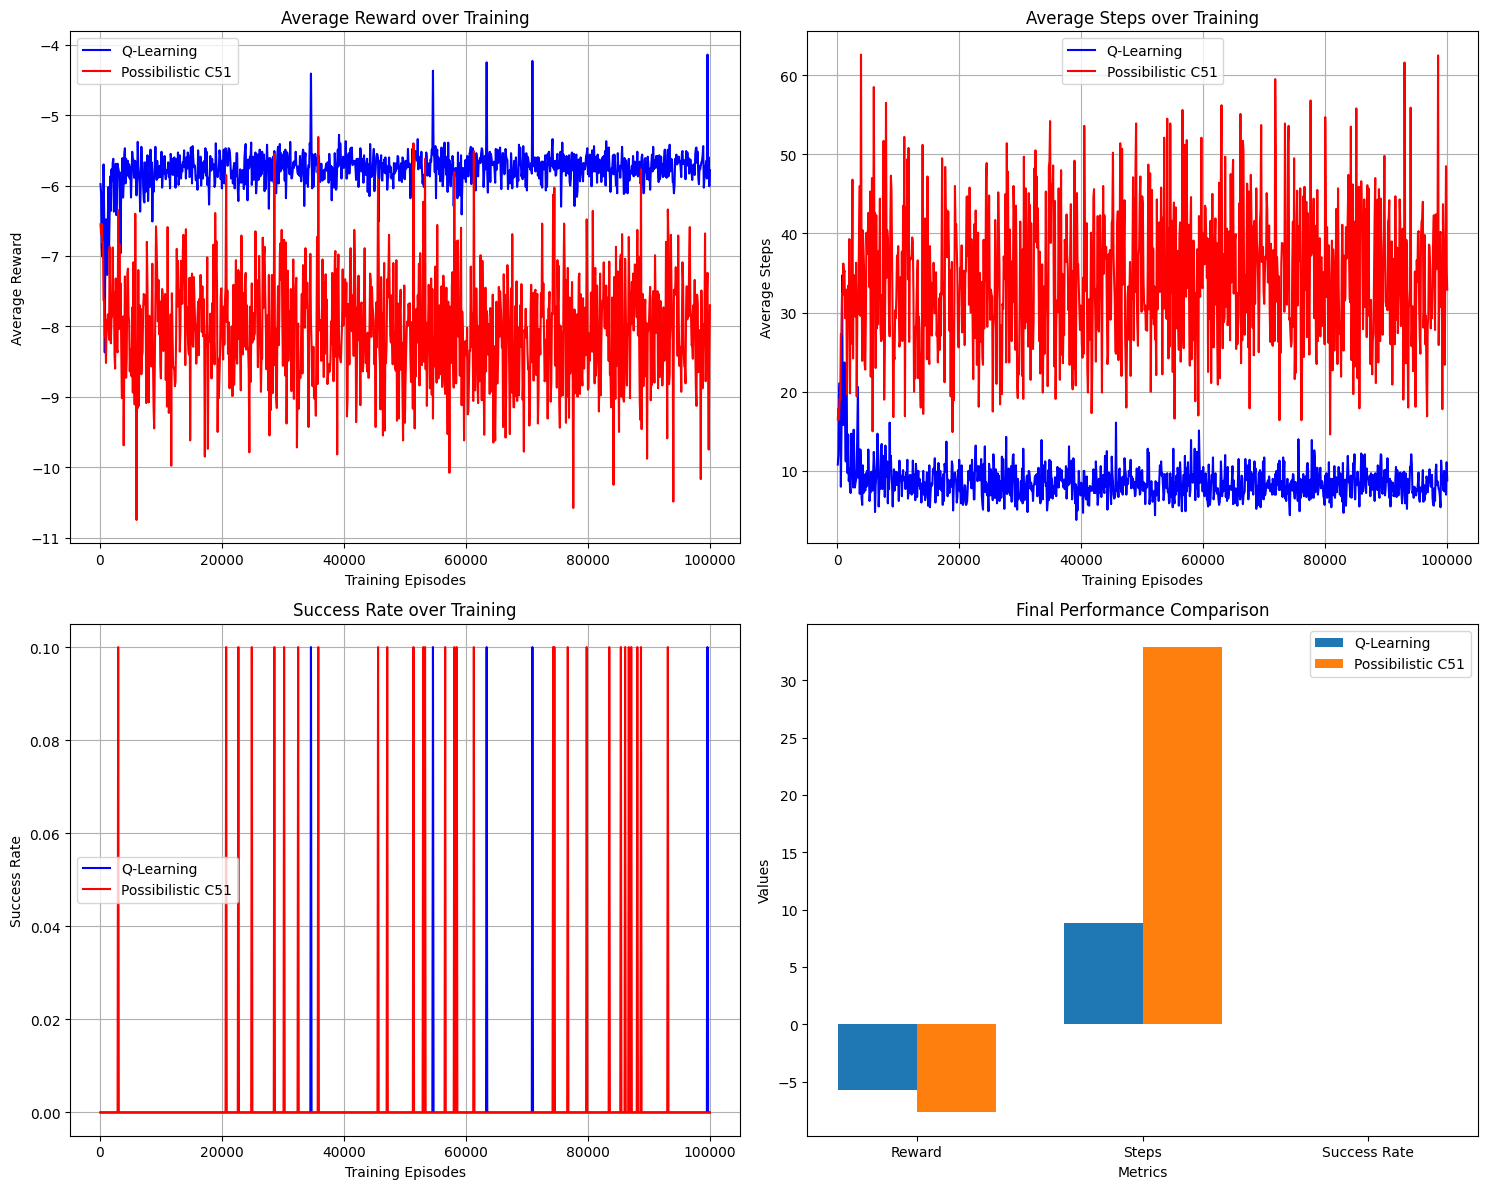

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# Create a custom gridworld environment based on FrozenLake
class GridWorld(gym.Env):
    def __init__(self, map_size=8, slip_prob=0.1, seed=None):
        np.random.seed(seed)
        self.map_size = map_size
        self.slip_prob = slip_prob
        
        # Generate a random map, but ensure it's solvable
        while True:
            self.desc = generate_random_map(size=map_size, p=0.8, seed=seed)
            env = gym.make('FrozenLake-v1', desc=self.desc, is_slippery=True)
            self.env = env.unwrapped
            # Run a simple check to see if the goal is reachable
            if self._is_solvable():
                break
        
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space
        self.reset()
    
    def _is_solvable(self):
        """Simple BFS to check if goal is reachable from start"""
        start = 0
        goal = self.map_size * self.map_size - 1
        visited = set([start])
        queue = [start]
        
        while queue:
            node = queue.pop(0)
            if node == goal:
                return True
            
            # Try all 4 directions
            row, col = node // self.map_size, node % self.map_size
            for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                new_row, new_col = row + dr, col + dc
                if (0 <= new_row < self.map_size and 0 <= new_col < self.map_size):
                    next_pos = new_row * self.map_size + new_col
                    tile = self.desc[new_row][new_col]
                    if tile != 'H' and next_pos not in visited:  # Not a hole
                        visited.add(next_pos)
                        queue.append(next_pos)
        
        return False
    
    def reset(self, seed=None):
        return self.env.reset(seed=seed)
    
    def step(self, action):
        # Random slip chance
        if np.random.random() < self.slip_prob:
            action = self.action_space.sample()
        
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Custom reward structure
        if terminated:
            if reward == 1:  # Reached goal
                reward = 10.0
            else:  # Fell in a hole
                reward = -5.0
        else:
            reward = -0.1  # Small penalty for each step to encourage efficiency
        
        return obs, reward, terminated, truncated, info
    
    def render(self):
        return self.env.render()


class TabularQLearning:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, exploration=1.0, exploration_decay=0.995, min_exploration=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration = exploration
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))
    
    def select_action(self, state, training=True):
        if training and np.random.random() < self.exploration:
            # Exploration: choose random action
            action = np.random.choice(self.action_size)
        else:
            # Exploitation: choose best action
            action = np.argmax(self.q_table[state])
        return action
    
    def update(self, state, action, reward, next_state, done):
        # Q-Learning update rule
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + (1 - done) * self.discount_factor * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error
        
        # Decay exploration rate
        if self.exploration > self.min_exploration:
            self.exploration *= self.exploration_decay
    
    def reset_exploration(self, value=1.0):
        self.exploration = value


class PossibilisticC51:
    def __init__(self, state_size, action_size, num_atoms=51, v_min=-10, v_max=10, 
                 learning_rate=0.1, discount_factor=0.99, exploration=1.0, 
                 exploration_decay=0.995, min_exploration=0.01, sigma=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration = exploration
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        self.sigma = sigma
        
        # Define support of distribution
        self.supports = np.linspace(v_min, v_max, num_atoms)
        
        # Initialize possibility distributions for each state-action pair to 1.0 (uniform prior)
        self.possibilities = np.ones((state_size, action_size, num_atoms))
    
    def compute_optimistic_q(self, state):
        """Compute optimistic Q-values from possibility distribution"""
        q_values = np.zeros(self.action_size)
        for action in range(self.action_size):
            # Compute Q value as the max of z_j * pi(z_j; s, a)
            q_values[action] = np.max(self.supports * self.possibilities[state, action])
        return q_values
    
    def select_action(self, state, training=True):
        if training and np.random.random() < self.exploration:
            # Exploration: choose random action
            action = np.random.choice(self.action_size)
        else:
            # Exploitation: choose action with highest optimistic Q-value
            q_values = self.compute_optimistic_q(state)
            action = np.argmax(q_values)
        return action
    
    def likelihood(self, reward, atoms):
        """Compute likelihood of observing reward for each atom"""
        return np.exp(-((reward - atoms) ** 2) / (2 * self.sigma ** 2))
    
    def update(self, state, action, reward, next_state, done):
        # Compute likelihood of observing the reward for each atom
        likelihood_values = self.likelihood(reward, self.supports)
        
        # Normalize likelihood to ensure maximum is 1 (possibilistic normalization)
        max_likelihood = np.max(likelihood_values)
        normalized_likelihood = likelihood_values / max_likelihood if max_likelihood > 0 else likelihood_values
        
        # Update possibility distribution using EMA (exponential moving average)
        self.possibilities[state, action] = (1 - self.learning_rate) * self.possibilities[state, action] + \
                                           self.learning_rate * normalized_likelihood
        
        # Decay exploration rate
        if self.exploration > self.min_exploration:
            self.exploration *= self.exploration_decay
    
    def reset_exploration(self, value=1.0):
        self.exploration = value


def evaluate_agent(env, agent, num_episodes=10):
    total_rewards = []
    total_steps = []
    success_rate = 0
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        steps = 0
        
        while not (done or truncated) and steps < 100:
            action = agent.select_action(state, training=False)
            next_state, reward, done, truncated, _ = env.step(action)
            
            episode_reward += reward
            state = next_state
            steps += 1
            
            if done and reward >= 0:  # Successfully reached goal
                success_rate += 1
        
        total_rewards.append(episode_reward)
        total_steps.append(steps)
    
    return {
        'avg_reward': np.mean(total_rewards),
        'avg_steps': np.mean(total_steps),
        'success_rate': success_rate / num_episodes
    }


def run_experiment(map_size=8, num_episodes=1000, eval_frequency=100, slip_prob=0.1, seed=42):
    # Set seeds for reproducibility
    np.random.seed(seed)
    
    # Create environment
    env = GridWorld(map_size=map_size, slip_prob=slip_prob, seed=seed)
    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    # Initialize agents
    q_learning = TabularQLearning(state_size, action_size)
    possibilistic_c51 = PossibilisticC51(state_size, action_size)
    
    # Training metrics
    q_learning_results = {'rewards': [], 'steps': [], 'success_rates': [], 'eval_steps': []}
    possibilistic_results = {'rewards': [], 'steps': [], 'success_rates': [], 'eval_steps': []}
    
    # Training loop
    for episode in tqdm(range(num_episodes)):
        # Train Q-Learning
        state, _ = env.reset(seed=episode)
        done = False
        truncated = False
        episode_reward_q = 0
        steps_q = 0
        
        while not (done or truncated) and steps_q < 100:
            action = q_learning.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            q_learning.update(state, action, reward, next_state, done)
            
            episode_reward_q += reward
            state = next_state
            steps_q += 1
        
        # Train Possibilistic C51
        state, _ = env.reset(seed=episode + num_episodes)  # Different seed to ensure fairness
        done = False
        truncated = False
        episode_reward_p = 0
        steps_p = 0
        
        while not (done or truncated) and steps_p < 100:
            action = possibilistic_c51.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            possibilistic_c51.update(state, action, reward, next_state, done)
            
            episode_reward_p += reward
            state = next_state
            steps_p += 1
        
        # Evaluate periodically
        if (episode + 1) % eval_frequency == 0:
            q_eval = evaluate_agent(env, q_learning)
            p_eval = evaluate_agent(env, possibilistic_c51)
            
            q_learning_results['rewards'].append(q_eval['avg_reward'])
            q_learning_results['steps'].append(q_eval['avg_steps'])
            q_learning_results['success_rates'].append(q_eval['success_rate'])
            q_learning_results['eval_steps'].append(episode + 1)
            
            possibilistic_results['rewards'].append(p_eval['avg_reward'])
            possibilistic_results['steps'].append(p_eval['avg_steps'])
            possibilistic_results['success_rates'].append(p_eval['success_rate'])
            possibilistic_results['eval_steps'].append(episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"Q-Learning - Avg Reward: {q_eval['avg_reward']:.2f}, Success Rate: {q_eval['success_rate']:.2f}")
            print(f"Possibilistic C51 - Avg Reward: {p_eval['avg_reward']:.2f}, Success Rate: {p_eval['success_rate']:.2f}")
            print("-" * 50)
    
    return q_learning_results, possibilistic_results, env


def visualize_results(q_learning_results, possibilistic_results):
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(q_learning_results['eval_steps'], q_learning_results['rewards'], 'b-', label='Q-Learning')
    plt.plot(possibilistic_results['eval_steps'], possibilistic_results['rewards'], 'r-', label='Possibilistic C51')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Training')
    plt.legend()
    plt.grid(True)
    
    # Plot steps
    plt.subplot(2, 2, 2)
    plt.plot(q_learning_results['eval_steps'], q_learning_results['steps'], 'b-', label='Q-Learning')
    plt.plot(possibilistic_results['eval_steps'], possibilistic_results['steps'], 'r-', label='Possibilistic C51')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Steps')
    plt.title('Average Steps over Training')
    plt.legend()
    plt.grid(True)
    
    # Plot success rates
    plt.subplot(2, 2, 3)
    plt.plot(q_learning_results['eval_steps'], q_learning_results['success_rates'], 'b-', label='Q-Learning')
    plt.plot(possibilistic_results['eval_steps'], possibilistic_results['success_rates'], 'r-', label='Possibilistic C51')
    plt.xlabel('Training Episodes')
    plt.ylabel('Success Rate')
    plt.title('Success Rate over Training')
    plt.legend()
    plt.grid(True)
    
    # Add a comparative bar plot for final performance
    plt.subplot(2, 2, 4)
    metrics = ['Reward', 'Steps', 'Success Rate']
    q_values = [q_learning_results['rewards'][-1], q_learning_results['steps'][-1], q_learning_results['success_rates'][-1]]
    p_values = [possibilistic_results['rewards'][-1], possibilistic_results['steps'][-1], possibilistic_results['success_rates'][-1]]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, q_values, width, label='Q-Learning')
    plt.bar(x + width/2, p_values, width, label='Possibilistic C51')
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Final Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def visualize_value_functions(env, q_learning, possibilistic_c51):
    map_size = env.map_size
    
    # Get Q-values for each state
    q_values = np.max(q_learning.q_table, axis=1).reshape(map_size, map_size)
    
    # Get optimistic Q-values for possibilistic C51
    p_values = np.zeros((env.observation_space.n,))
    for s in range(env.observation_space.n):
        p_values[s] = np.max(possibilistic_c51.compute_optimistic_q(s))
    p_values = p_values.reshape(map_size, map_size)
    
    # Create map visualization
    map_vis = np.zeros((map_size, map_size))
    for i in range(map_size):
        for j in range(map_size):
            cell = env.desc[i][j]
            if cell == 'H':  # Hole
                map_vis[i, j] = -1
            elif cell == 'G':  # Goal
                map_vis[i, j] = 1
            elif cell == 'S':  # Start
                map_vis[i, j] = 0.5
            else:  # Regular cell
                map_vis[i, j] = 0
    
    plt.figure(figsize=(18, 6))
    
    # Plot environment map
    plt.subplot(1, 3, 1)
    sns.heatmap(map_vis, cmap='coolwarm', cbar=True, square=True, 
                xticklabels=False, yticklabels=False, annot=False)
    plt.title('GridWorld Environment')
    
    # Plot Q-Learning value function
    plt.subplot(1, 3, 2)
    sns.heatmap(q_values, cmap='viridis', cbar=True, square=True, 
                xticklabels=False, yticklabels=False, annot=False)
    plt.title('Q-Learning Value Function')
    
    # Plot Possibilistic C51 value function
    plt.subplot(1, 3, 3)
    sns.heatmap(p_values, cmap='viridis', cbar=True, square=True, 
                xticklabels=False, yticklabels=False, annot=False)
    plt.title('Possibilistic C51 Value Function')
    
    plt.tight_layout()
    plt.show()


def run_multiple_experiments(map_sizes=[5, 8, 10], slip_probs=[0.0, 0.1, 0.2], num_episodes=500):
    results = []
    
    for map_size in map_sizes:
        for slip_prob in slip_probs:
            print(f"Running experiment with map_size={map_size}, slip_prob={slip_prob}")
            
            q_learning_results, possibilistic_results, _ = run_experiment(
                map_size=map_size, 
                num_episodes=num_episodes,
                eval_frequency=100,
                slip_prob=slip_prob
            )
            
            # Store final metrics
            results.append({
                'map_size': map_size,
                'slip_prob': slip_prob,
                'q_learning_reward': q_learning_results['rewards'][-1],
                'possibilistic_reward': possibilistic_results['rewards'][-1],
                'q_learning_steps': q_learning_results['steps'][-1],
                'possibilistic_steps': possibilistic_results['steps'][-1],
                'q_learning_success': q_learning_results['success_rates'][-1],
                'possibilistic_success': possibilistic_results['success_rates'][-1]
            })
    
    # Convert to DataFrame for easy analysis
    df = pd.DataFrame(results)
    
    # Plot the results comparison
    plt.figure(figsize=(15, 12))
    
    metrics = ['reward', 'steps', 'success']
    titles = ['Average Reward', 'Average Steps', 'Success Rate']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plt.subplot(3, 1, i+1)
        
        for slip_prob in slip_probs:
            df_subset = df[df['slip_prob'] == slip_prob]
            
            q_metric = f'q_learning_{metric}'
            p_metric = f'possibilistic_{metric}'
            
            plt.plot(df_subset['map_size'], df_subset[q_metric], 'o-', 
                     label=f'Q-Learning (slip={slip_prob})')
            plt.plot(df_subset['map_size'], df_subset[p_metric], 's--', 
                     label=f'Possibilistic C51 (slip={slip_prob})')
        
        plt.xlabel('Map Size')
        plt.ylabel(title)
        plt.title(f'Effect of Map Size and Slip Probability on {title}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return df


if __name__ == "__main__":
    # Run a single experiment and visualize results
    q_learning_results, possibilistic_results, env = run_experiment(
        map_size=7, 
        num_episodes=100000, 
        eval_frequency=100, 
        slip_prob=0.4
    )
    
    visualize_results(q_learning_results, possibilistic_results)
    
    # # Create Q-Learning and Possibilistic C51 agents for visualization
    # state_size = env.observation_space.n
    # action_size = env.action_space.n
    
    # q_learning = TabularQLearning(state_size, action_size)
    # possibilistic_c51 = PossibilisticC51(state_size, action_size)
    
    # # Train them for visualization
    # num_episodes = 1000
    # for episode in range(num_episodes):
    #     # Train Q-Learning
    #     state, _ = env.reset(seed=episode)
    #     done = False
    #     while not done:
    #         action = q_learning.select_action(state)
    #         next_state, reward, done, truncated, _ = env.step(action)
    #         q_learning.update(state, action, reward, next_state, done)
    #         state = next_state
    #         if truncated:
    #             break
        
    #     # Train Possibilistic C51
    #     state, _ = env.reset(seed=episode + num_episodes)
    #     done = False
    #     while not done:
    #         action = possibilistic_c51.select_action(state)
    #         next_state, reward, done, truncated, _ = env.step(action)
    #         possibilistic_c51.update(state, action, reward, next_state, done)
    #         state = next_state
    #         if truncated:
    #             break
    
    # visualize_value_functions(env, q_learning, possibilistic_c51)
    
    # # Run multiple experiments with different parameters
    # results_df = run_multiple_experiments()
    # print(results_df)

  4%|████▋                                                                                                                        | 378/10000 [00:00<00:05, 1778.60it/s]

Episode 100/10000
Q-Learning - Avg Reward: 17.23, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -5.69, Success Rate: 0.00
--------------------------------------------------
Episode 200/10000
Q-Learning - Avg Reward: 19.06, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -0.38, Success Rate: 0.00
--------------------------------------------------
Episode 300/10000
Q-Learning - Avg Reward: 13.93, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -0.13, Success Rate: 0.00
--------------------------------------------------
Episode 400/10000
Q-Learning - Avg Reward: 15.24, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.11, Success Rate: 0.00
--------------------------------------------------


  7%|█████████                                                                                                                    | 724/10000 [00:00<00:05, 1648.45it/s]

Episode 500/10000
Q-Learning - Avg Reward: 10.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.48, Success Rate: 0.00
--------------------------------------------------
Episode 600/10000
Q-Learning - Avg Reward: 18.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -0.77, Success Rate: 0.00
--------------------------------------------------
Episode 700/10000
Q-Learning - Avg Reward: -2.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 800/10000
Q-Learning - Avg Reward: 15.72, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 12%|███████████████▎                                                                                                            | 1234/10000 [00:00<00:05, 1631.87it/s]

Episode 900/10000
Q-Learning - Avg Reward: 19.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 1000/10000
Q-Learning - Avg Reward: 15.67, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.18, Success Rate: 0.00
--------------------------------------------------
Episode 1100/10000
Q-Learning - Avg Reward: 19.27, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.07, Success Rate: 0.00
--------------------------------------------------
Episode 1200/10000
Q-Learning - Avg Reward: 15.14, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.09, Success Rate: 0.00
--------------------------------------------------


 16%|███████████████████▎                                                                                                        | 1562/10000 [00:00<00:05, 1624.88it/s]

Episode 1300/10000
Q-Learning - Avg Reward: 14.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 1400/10000
Q-Learning - Avg Reward: 22.21, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.92, Success Rate: 0.00
--------------------------------------------------
Episode 1500/10000
Q-Learning - Avg Reward: 17.35, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.55, Success Rate: 0.00
--------------------------------------------------
Episode 1600/10000
Q-Learning - Avg Reward: 16.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.70, Success Rate: 0.00
--------------------------------------------------


 19%|███████████████████████▍                                                                                                    | 1888/10000 [00:01<00:05, 1600.44it/s]

Episode 1700/10000
Q-Learning - Avg Reward: 13.69, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 1800/10000
Q-Learning - Avg Reward: 9.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.32, Success Rate: 0.00
--------------------------------------------------
Episode 1900/10000
Q-Learning - Avg Reward: 17.99, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.47, Success Rate: 0.00
--------------------------------------------------
Episode 2000/10000
Q-Learning - Avg Reward: 19.66, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -0.43, Success Rate: 0.00
--------------------------------------------------


 22%|███████████████████████████▎                                                                                                | 2207/10000 [00:01<00:05, 1444.02it/s]

Episode 2100/10000
Q-Learning - Avg Reward: 11.40, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.52, Success Rate: 0.00
--------------------------------------------------
Episode 2200/10000
Q-Learning - Avg Reward: 8.64, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.47, Success Rate: 0.00
--------------------------------------------------
Episode 2300/10000
Q-Learning - Avg Reward: 8.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.42, Success Rate: 0.00
--------------------------------------------------


 25%|███████████████████████████████                                                                                             | 2502/10000 [00:01<00:05, 1438.52it/s]

Episode 2400/10000
Q-Learning - Avg Reward: 6.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.39, Success Rate: 0.00
--------------------------------------------------
Episode 2500/10000
Q-Learning - Avg Reward: 6.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -0.06, Success Rate: 0.00
--------------------------------------------------
Episode 2600/10000
Q-Learning - Avg Reward: 8.40, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 29%|████████████████████████████████████▎                                                                                       | 2930/10000 [00:01<00:05, 1317.89it/s]

Episode 2700/10000
Q-Learning - Avg Reward: 23.13, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 2.34, Success Rate: 0.00
--------------------------------------------------
Episode 2800/10000
Q-Learning - Avg Reward: 14.20, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 0.96, Success Rate: 0.00
--------------------------------------------------
Episode 2900/10000
Q-Learning - Avg Reward: -2.18, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.80, Success Rate: 0.00
--------------------------------------------------
Episode 3000/10000
Q-Learning - Avg Reward: 7.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.53, Success Rate: 0.00
--------------------------------------------------


 34%|██████████████████████████████████████████▏                                                                                 | 3400/10000 [00:02<00:04, 1483.33it/s]

Episode 3100/10000
Q-Learning - Avg Reward: 16.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.96, Success Rate: 0.00
--------------------------------------------------
Episode 3200/10000
Q-Learning - Avg Reward: 6.44, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.52, Success Rate: 0.00
--------------------------------------------------
Episode 3300/10000
Q-Learning - Avg Reward: 1.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.76, Success Rate: 0.00
--------------------------------------------------
Episode 3400/10000
Q-Learning - Avg Reward: 18.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 3500/10000
Q-Learning - Avg Reward: 0.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.95, Success Rate: 0.00
--------------------------------------------------


 39%|███████████████████████████████████████████████▉                                                                            | 3867/10000 [00:02<00:04, 1518.79it/s]

Episode 3600/10000
Q-Learning - Avg Reward: 9.65, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.79, Success Rate: 0.00
--------------------------------------------------
Episode 3700/10000
Q-Learning - Avg Reward: 28.52, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.37, Success Rate: 0.00
--------------------------------------------------
Episode 3800/10000
Q-Learning - Avg Reward: 20.54, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.50, Success Rate: 0.00
--------------------------------------------------
Episode 3900/10000
Q-Learning - Avg Reward: 20.15, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 44%|█████████████████████████████████████████████████████▉                                                                      | 4353/10000 [00:02<00:03, 1565.51it/s]

Episode 4000/10000
Q-Learning - Avg Reward: -2.94, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 4100/10000
Q-Learning - Avg Reward: 2.82, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 1.16, Success Rate: 0.00
--------------------------------------------------
Episode 4200/10000
Q-Learning - Avg Reward: 8.19, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.04, Success Rate: 0.00
--------------------------------------------------
Episode 4300/10000
Q-Learning - Avg Reward: 22.16, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.46, Success Rate: 0.00
--------------------------------------------------


 47%|██████████████████████████████████████████████████████████                                                                  | 4679/10000 [00:03<00:03, 1593.23it/s]

Episode 4400/10000
Q-Learning - Avg Reward: 12.53, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.18, Success Rate: 0.00
--------------------------------------------------
Episode 4500/10000
Q-Learning - Avg Reward: 17.45, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.16, Success Rate: 0.00
--------------------------------------------------
Episode 4600/10000
Q-Learning - Avg Reward: 16.12, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.40, Success Rate: 0.00
--------------------------------------------------
Episode 4700/10000
Q-Learning - Avg Reward: 11.56, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 2.31, Success Rate: 0.00
--------------------------------------------------


 50%|██████████████████████████████████████████████████████████████                                                              | 5000/10000 [00:03<00:03, 1575.73it/s]

Episode 4800/10000
Q-Learning - Avg Reward: 15.81, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.26, Success Rate: 0.00
--------------------------------------------------
Episode 4900/10000
Q-Learning - Avg Reward: 12.62, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.18, Success Rate: 0.00
--------------------------------------------------
Episode 5000/10000
Q-Learning - Avg Reward: 9.28, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 5100/10000
Q-Learning - Avg Reward: -1.73, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.82, Success Rate: 0.00
--------------------------------------------------


 55%|████████████████████████████████████████████████████████████████████                                                        | 5490/10000 [00:03<00:02, 1610.73it/s]

Episode 5200/10000
Q-Learning - Avg Reward: -2.92, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 5300/10000
Q-Learning - Avg Reward: 19.46, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.67, Success Rate: 0.00
--------------------------------------------------
Episode 5400/10000
Q-Learning - Avg Reward: 20.13, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.11, Success Rate: 0.00
--------------------------------------------------
Episode 5500/10000
Q-Learning - Avg Reward: 13.85, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.95, Success Rate: 0.00
--------------------------------------------------
Episode 5600/10000
Q-Learning - Avg Reward: 10.58, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.04, Success Rate: 0.00
--------------------------------------------------


 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 5967/10000 [00:03<00:02, 1559.37it/s]

Episode 5700/10000
Q-Learning - Avg Reward: 13.91, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 5800/10000
Q-Learning - Avg Reward: 19.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.20, Success Rate: 0.00
--------------------------------------------------
Episode 5900/10000
Q-Learning - Avg Reward: 18.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.63, Success Rate: 0.00
--------------------------------------------------
Episode 6000/10000
Q-Learning - Avg Reward: 13.19, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 0.00, Success Rate: 0.00
--------------------------------------------------


 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 6279/10000 [00:04<00:02, 1538.20it/s]

Episode 6100/10000
Q-Learning - Avg Reward: 17.71, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.33, Success Rate: 0.00
--------------------------------------------------
Episode 6200/10000
Q-Learning - Avg Reward: 14.68, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.88, Success Rate: 0.00
--------------------------------------------------
Episode 6300/10000
Q-Learning - Avg Reward: 26.27, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.21, Success Rate: 0.00
--------------------------------------------------
Episode 6400/10000
Q-Learning - Avg Reward: 13.48, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.30, Success Rate: 0.00
--------------------------------------------------


 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 6782/10000 [00:04<00:01, 1633.70it/s]

Episode 6500/10000
Q-Learning - Avg Reward: 13.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.22, Success Rate: 0.00
--------------------------------------------------
Episode 6600/10000
Q-Learning - Avg Reward: 11.33, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.85, Success Rate: 0.00
--------------------------------------------------
Episode 6700/10000
Q-Learning - Avg Reward: 15.32, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.51, Success Rate: 0.00
--------------------------------------------------
Episode 6800/10000
Q-Learning - Avg Reward: 19.17, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 3.61, Success Rate: 0.00
--------------------------------------------------
Episode 6900/10000
Q-Learning - Avg Reward: 18.40, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 9.21, Success Rate: 0.00
--------------------------------------------------


 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7278/10000 [00:04<00:01, 1628.20it/s]

Episode 7000/10000
Q-Learning - Avg Reward: 16.57, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -0.61, Success Rate: 0.00
--------------------------------------------------
Episode 7100/10000
Q-Learning - Avg Reward: 16.16, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 0.47, Success Rate: 0.00
--------------------------------------------------
Episode 7200/10000
Q-Learning - Avg Reward: 18.09, Success Rate: 0.00
Possibilistic C51 - Avg Reward: 1.48, Success Rate: 0.00
--------------------------------------------------
Episode 7300/10000
Q-Learning - Avg Reward: 7.02, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.41, Success Rate: 0.00
--------------------------------------------------


 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7600/10000 [00:04<00:01, 1557.88it/s]

Episode 7400/10000
Q-Learning - Avg Reward: -3.00, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.21, Success Rate: 0.00
--------------------------------------------------
Episode 7500/10000
Q-Learning - Avg Reward: 10.04, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.91, Success Rate: 0.00
--------------------------------------------------
Episode 7600/10000
Q-Learning - Avg Reward: 19.76, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -1.80, Success Rate: 0.00
--------------------------------------------------
Episode 7700/10000
Q-Learning - Avg Reward: 11.01, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.63, Success Rate: 0.00
--------------------------------------------------


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8089/10000 [00:05<00:01, 1597.51it/s]

Episode 7800/10000
Q-Learning - Avg Reward: -0.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 7900/10000
Q-Learning - Avg Reward: 15.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.74, Success Rate: 0.00
--------------------------------------------------
Episode 8000/10000
Q-Learning - Avg Reward: 17.11, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8100/10000
Q-Learning - Avg Reward: -3.25, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8408/10000 [00:05<00:01, 1562.19it/s]

Episode 8200/10000
Q-Learning - Avg Reward: 18.74, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8300/10000
Q-Learning - Avg Reward: 11.98, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8400/10000
Q-Learning - Avg Reward: 17.33, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8500/10000
Q-Learning - Avg Reward: 13.88, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8901/10000 [00:05<00:00, 1585.68it/s]

Episode 8600/10000
Q-Learning - Avg Reward: 13.78, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8700/10000
Q-Learning - Avg Reward: 16.70, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8800/10000
Q-Learning - Avg Reward: 8.43, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 8900/10000
Q-Learning - Avg Reward: 16.84, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9218/10000 [00:05<00:00, 1557.98it/s]

Episode 9000/10000
Q-Learning - Avg Reward: 14.15, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 9100/10000
Q-Learning - Avg Reward: 13.34, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 9200/10000
Q-Learning - Avg Reward: 15.35, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.83, Success Rate: 0.00
--------------------------------------------------
Episode 9300/10000
Q-Learning - Avg Reward: 15.98, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9700/10000 [00:06<00:00, 1589.62it/s]

Episode 9400/10000
Q-Learning - Avg Reward: 6.55, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 9500/10000
Q-Learning - Avg Reward: 15.87, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.75, Success Rate: 0.00
--------------------------------------------------
Episode 9600/10000
Q-Learning - Avg Reward: 18.03, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.15, Success Rate: 0.00
--------------------------------------------------
Episode 9700/10000
Q-Learning - Avg Reward: 19.16, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1531.85it/s]

Episode 9800/10000
Q-Learning - Avg Reward: 11.59, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -2.61, Success Rate: 0.00
--------------------------------------------------
Episode 9900/10000
Q-Learning - Avg Reward: 17.97, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------
Episode 10000/10000
Q-Learning - Avg Reward: 7.79, Success Rate: 0.00
Possibilistic C51 - Avg Reward: -3.00, Success Rate: 0.00
--------------------------------------------------


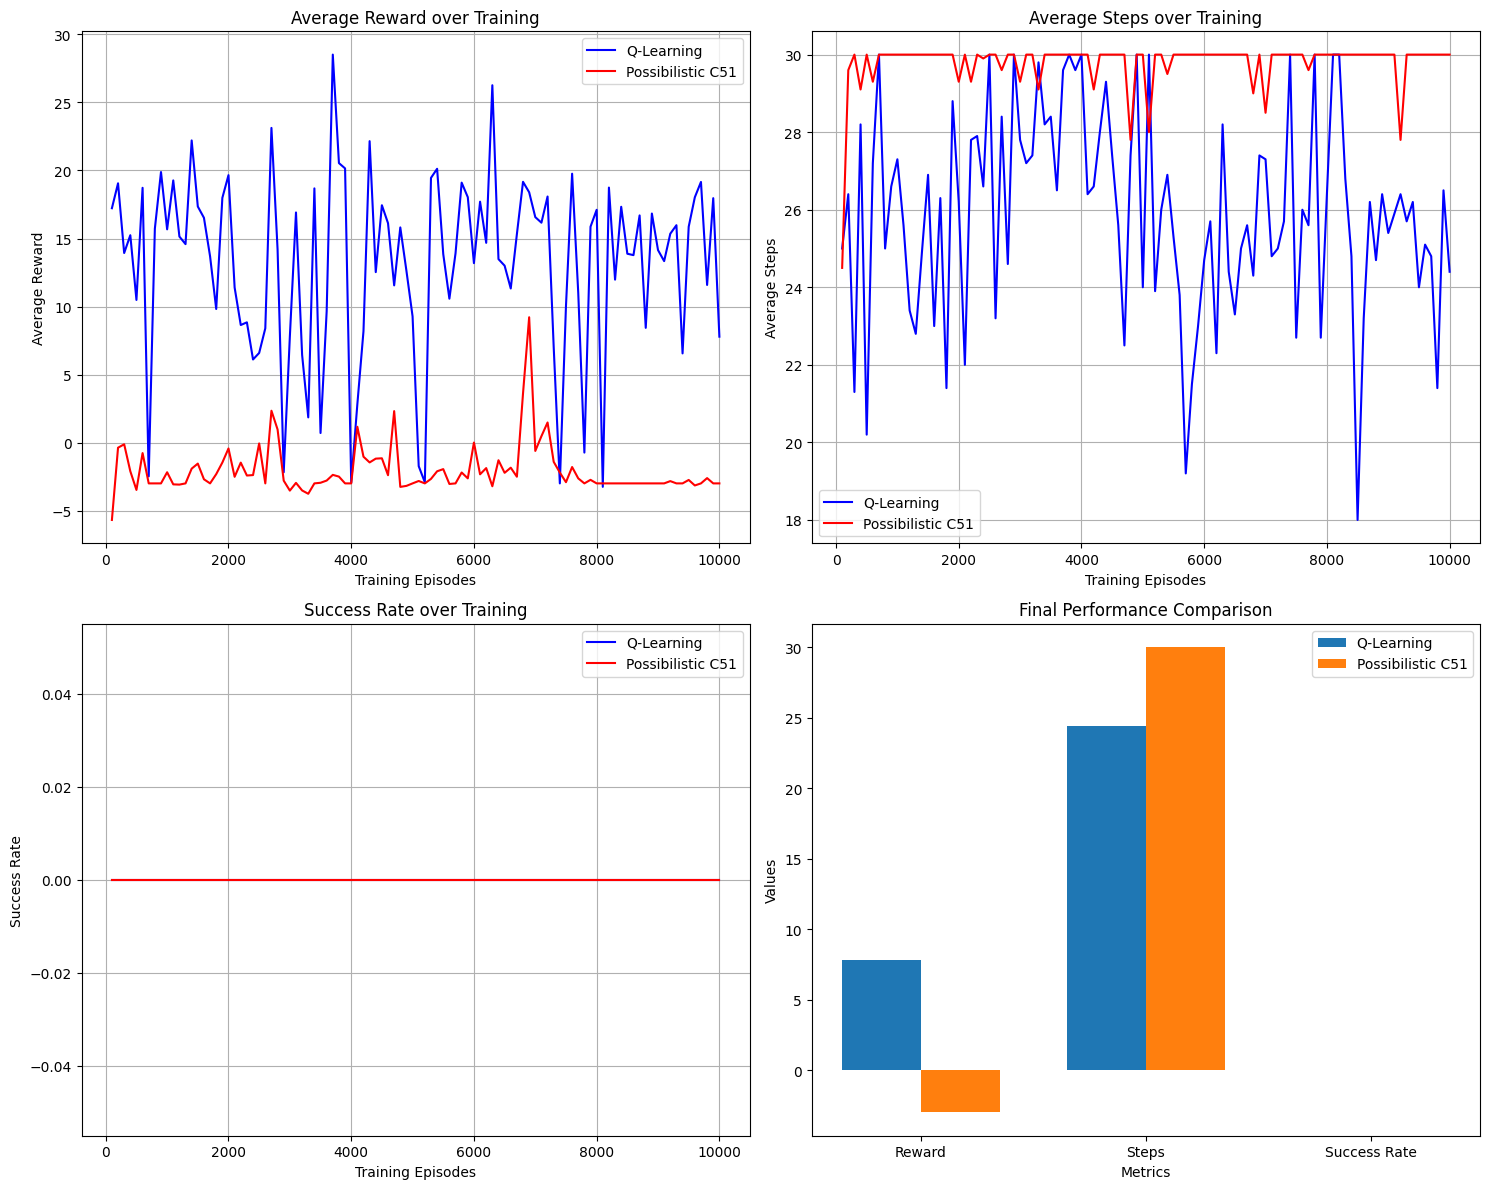

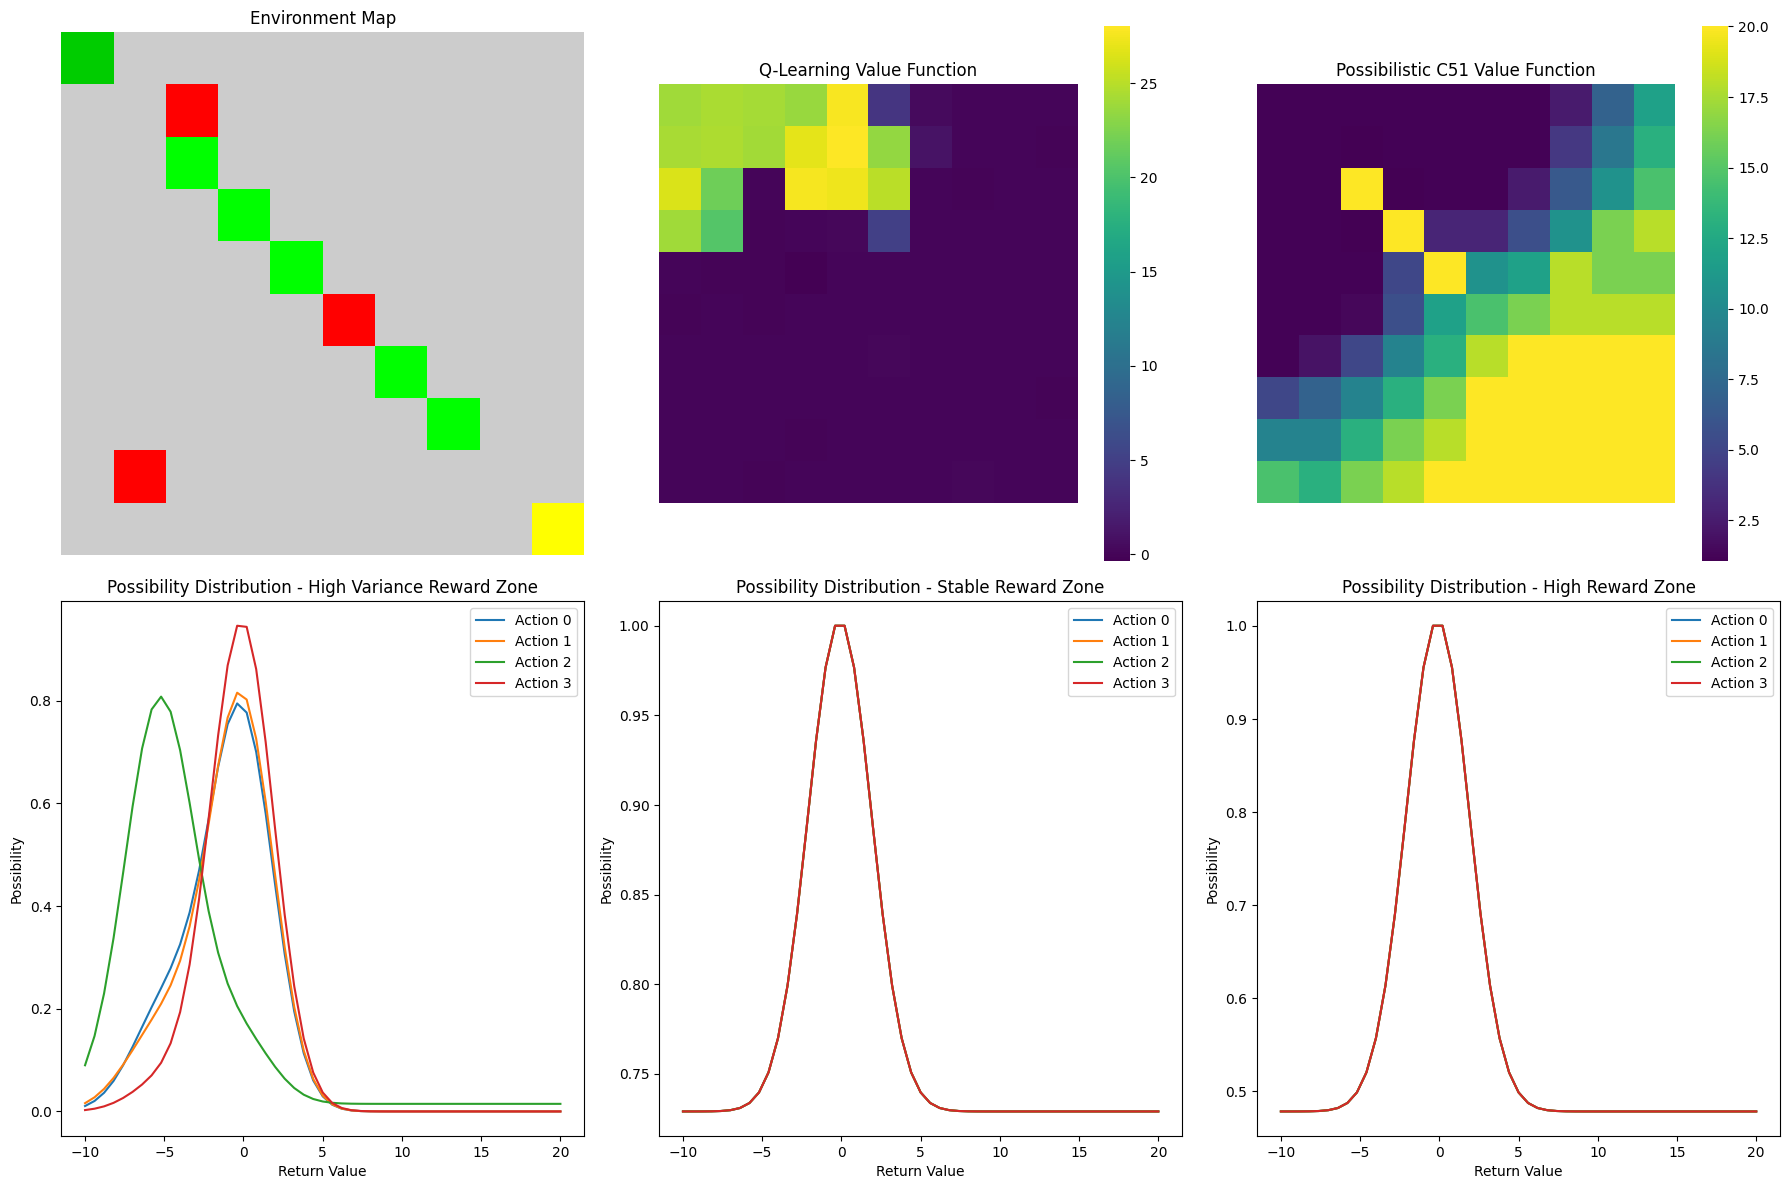

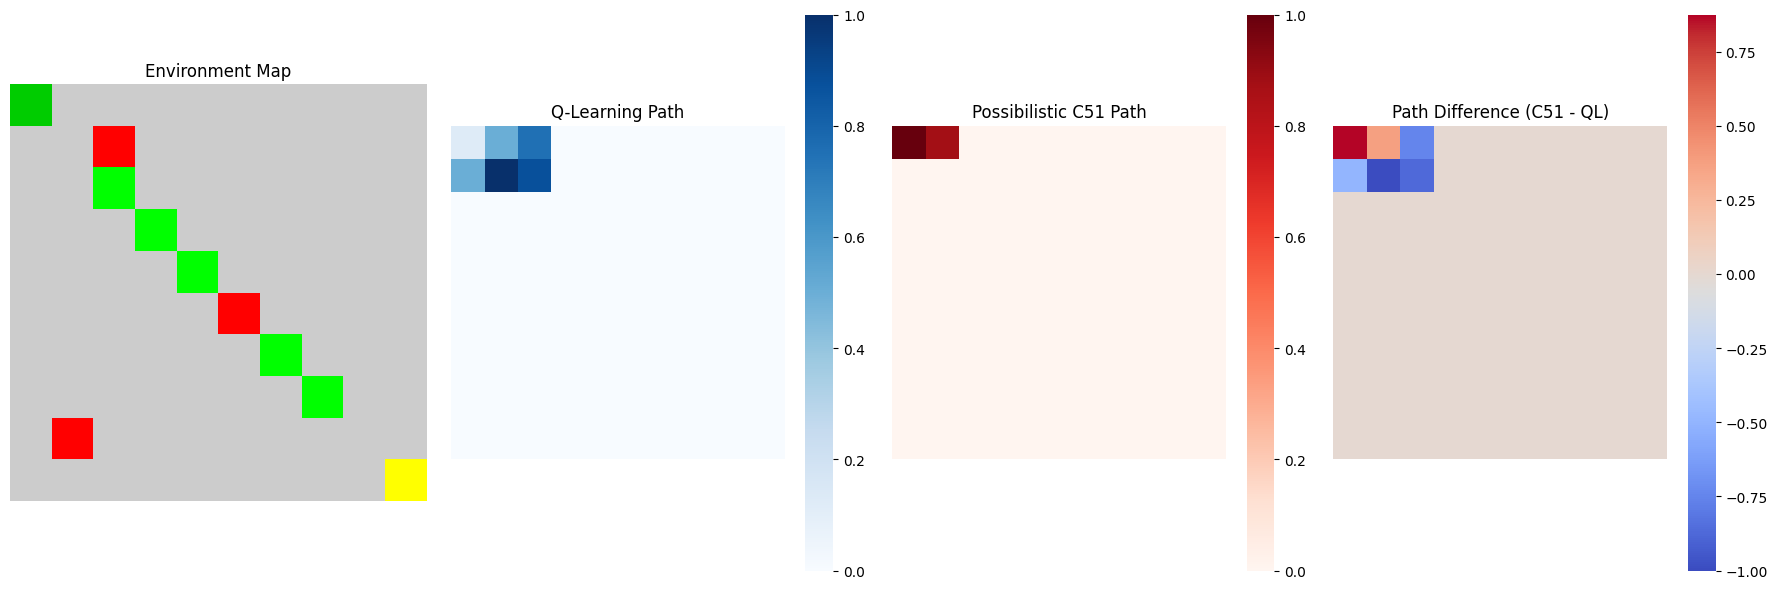

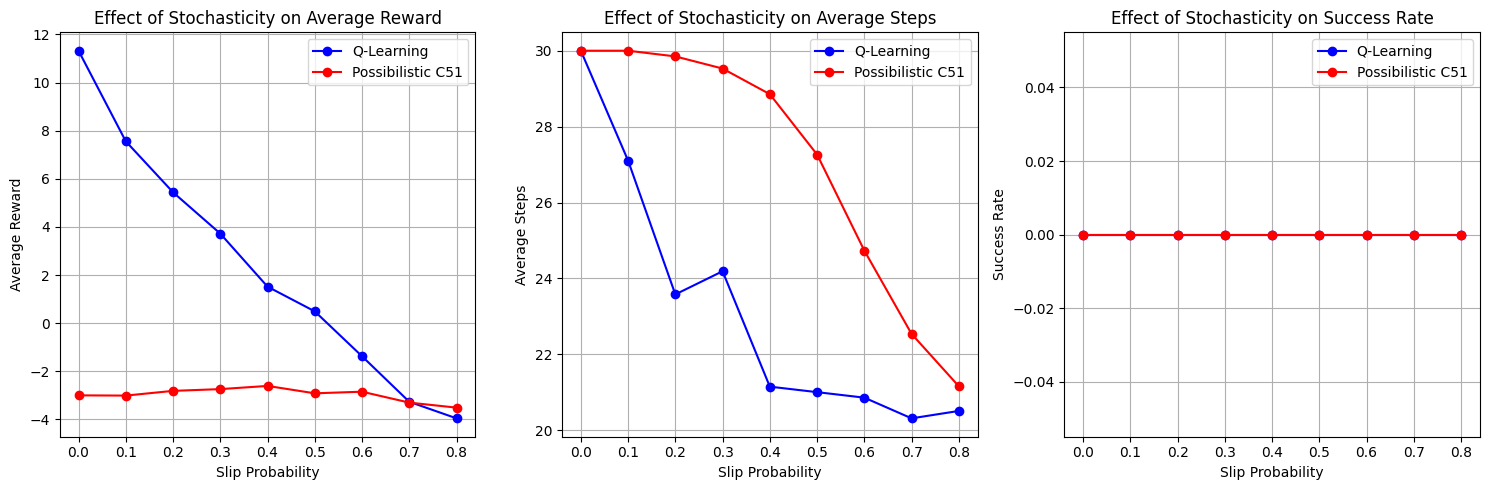

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

class UncertainRewardGridWorld(gym.Env):
    """
    A GridWorld environment designed to showcase the advantages of distributional RL.
    Features:
    1. Multiple reward zones with variable reward distributions
    2. Traps with negative rewards
    3. Delayed rewards (sparse reward setting)
    4. Stochastic transitions
    5. A deceptive shortcut that seems good initially but is suboptimal
    """
    
    def __init__(self, size=10, slip_prob=0.2, seed=None):
        np.random.seed(seed)
        self.size = size
        self.slip_prob = slip_prob
        self.action_space = spaces.Discrete(4)  # Up, Right, Down, Left
        self.observation_space = spaces.Discrete(size * size)
        
        # Create grid layout
        self._create_grid()
        
        # Create transition dynamics
        self._create_transition_matrix()
        
        # Keep track of steps for timeout
        self.steps = 0
        self.max_steps = size * 3
        
        # For rendering
        self.agent_pos = None
    
    def _create_grid(self):
        """Create the grid with special cells"""
        self.grid = np.zeros((self.size, self.size))
        
        # Place the goal in the far corner
        self.goal_pos = (self.size - 1, self.size - 1)
        self.grid[self.goal_pos] = 4  # Code 4 for goal
        
        # Place start in opposite corner
        self.start_pos = (0, 0)
        self.grid[self.start_pos] = 1  # Code 1 for start
        
        # Define reward zones (with stochastic rewards)
        self.reward_zones = []
        
        # A high-variance reward zone near the start
        high_var_pos = (1, 2)
        self.grid[high_var_pos] = 2  # Code 2 for reward zone
        self.reward_zones.append({"pos": high_var_pos, "mean": 2.0, "std": 3.0})
        
        # A lower-mean but stable reward zone in the middle
        stable_pos = (self.size // 2, self.size // 2)
        self.grid[stable_pos] = 2
        self.reward_zones.append({"pos": stable_pos, "mean": 1.0, "std": 0.2})
        
        # A high-reward zone that requires a longer path
        high_reward_pos = (self.size - 2, 1)
        self.grid[high_reward_pos] = 2
        self.reward_zones.append({"pos": high_reward_pos, "mean": 4.0, "std": 1.0})
        
        # Place traps
        num_traps = self.size // 2
        trap_positions = []
        
        # Create a deceptive path with traps
        # Make a path that looks like a shortcut but has traps
        for i in range(2, self.size - 2):
            trap_pos = (i, i)
            if self.grid[trap_pos] == 0:  # Don't overwrite other special cells
                self.grid[trap_pos] = 3  # Code 3 for trap
                trap_positions.append(trap_pos)
        
        # Add some random traps in remaining spaces
        while len(trap_positions) < num_traps:
            i, j = np.random.randint(1, self.size - 1), np.random.randint(1, self.size - 1)
            if self.grid[i, j] == 0:  # Only place on empty cells
                self.grid[i, j] = 3
                trap_positions.append((i, j))
        
        self.trap_positions = trap_positions
    
    def _create_transition_matrix(self):
        """Create the transition matrix for the environment"""
        # Action mapping: 0=Up, 1=Right, 2=Down, 3=Left
        self.action_effects = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    
    def _get_obs_from_pos(self, pos):
        """Convert (row, col) position to flat observation index"""
        return pos[0] * self.size + pos[1]
    
    def _get_pos_from_obs(self, obs):
        """Convert flat observation index to (row, col) position"""
        return (obs // self.size, obs % self.size)
    
    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        self.agent_pos = self.start_pos
        self.steps = 0
        
        # Reset the rewards in the reward zones
        for zone in self.reward_zones:
            zone["current_reward"] = np.random.normal(zone["mean"], zone["std"])
        
        return self._get_obs_from_pos(self.agent_pos), {}
    
    def step(self, action):
        self.steps += 1
        
        # Stochastic transitions - might slip to a different action
        if np.random.random() < self.slip_prob:
            # Pick a random action different from the intended one
            available_actions = [a for a in range(4) if a != action]
            action = np.random.choice(available_actions)
        
        # Calculate new position
        dr, dc = self.action_effects[action]
        new_row = self.agent_pos[0] + dr
        new_col = self.agent_pos[1] + dc
        
        # Check boundaries
        if 0 <= new_row < self.size and 0 <= new_col < self.size:
            self.agent_pos = (new_row, new_col)
        
        # Get observation
        obs = self._get_obs_from_pos(self.agent_pos)
        
        # Calculate reward and check if done
        reward = -0.1  # Small penalty for each step
        done = False
        truncated = False
        info = {}
        
        # Check cell type
        cell_type = self.grid[self.agent_pos]
        
        if cell_type == 2:  # Reward zone
            # Find the corresponding reward zone
            for zone in self.reward_zones:
                if zone["pos"] == self.agent_pos:
                    reward += zone["current_reward"]
                    # Regenerate the reward for next visit
                    zone["current_reward"] = np.random.normal(zone["mean"], zone["std"])
                    break
        
        elif cell_type == 3:  # Trap
            # Traps have variable negative rewards
            reward = -np.random.uniform(3.0, 7.0)
            done = True
            info["trap"] = True
        
        elif cell_type == 4:  # Goal
            reward = 10.0
            done = True
            info["goal"] = True
        
        # Check for timeout
        if self.steps >= self.max_steps:
            truncated = True
        
        return obs, reward, done, truncated, info
    
    def get_grid_with_agent(self):
        """Returns a grid with agent position for visualization"""
        grid_with_agent = self.grid.copy()
        
        # Mark agent position
        if grid_with_agent[self.agent_pos] == 0:  # Don't overwrite special cells in visualization
            grid_with_agent[self.agent_pos] = 5  # Code 5 for agent
        
        return grid_with_agent
    
    def render(self):
        """Simple console rendering"""
        grid_with_agent = self.get_grid_with_agent()
        
        # Define symbols for cell types
        symbols = {
            0: '.',  # Empty
            1: 'S',  # Start
            2: 'R',  # Reward zone
            3: 'T',  # Trap
            4: 'G',  # Goal
            5: 'A',  # Agent
        }
        
        # Print the grid
        for i in range(self.size):
            row = ''
            for j in range(self.size):
                cell_type = int(grid_with_agent[i, j])
                row += symbols[cell_type] + ' '
            print(row)
        print()


class TabularQLearning:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.99, 
                 exploration=1.0, exploration_decay=0.995, min_exploration=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration = exploration
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        
        # Initialize Q-table with small random values to break ties
        self.q_table = np.random.uniform(-0.1, 0.1, (state_size, action_size))
    
    def select_action(self, state, training=True):
        if training and np.random.random() < self.exploration:
            # Exploration: choose random action
            action = np.random.choice(self.action_size)
        else:
            # Exploitation: choose best action
            action = np.argmax(self.q_table[state])
        return action
    
    def update(self, state, action, reward, next_state, done):
        # Q-Learning update rule
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + (1 - done) * self.discount_factor * self.q_table[next_state, best_next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error
        
        # Decay exploration rate
        if self.exploration > self.min_exploration:
            self.exploration *= self.exploration_decay
    
    def reset_exploration(self, value=1.0):
        self.exploration = value


class PossibilisticC51:
    def __init__(self, state_size, action_size, num_atoms=51, v_min=-10, v_max=20, 
                 learning_rate=0.1, discount_factor=0.99, exploration=1.0, 
                 exploration_decay=0.995, min_exploration=0.01, sigma=1.0):
        self.state_size = state_size
        self.action_size = action_size
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration = exploration
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        self.sigma = sigma
        
        # Define support of distribution
        self.supports = np.linspace(v_min, v_max, num_atoms)
        
        # Initialize possibility distributions for each state-action pair to 1.0 (uniform prior)
        self.possibilities = np.ones((state_size, action_size, num_atoms))
    
    def compute_optimistic_q(self, state):
        """Compute optimistic Q-values from possibility distribution"""
        q_values = np.zeros(self.action_size)
        for action in range(self.action_size):
            # Compute Q value as the max of z_j * pi(z_j; s, a)
            q_values[action] = np.max(self.supports * self.possibilities[state, action])
        return q_values
    
    def select_action(self, state, training=True):
        if training and np.random.random() < self.exploration:
            # Exploration: choose random action
            action = np.random.choice(self.action_size)
        else:
            # Exploitation: choose action with highest optimistic Q-value
            q_values = self.compute_optimistic_q(state)
            action = np.argmax(q_values)
        return action
    
    def likelihood(self, reward, atoms):
        """Compute likelihood of observing reward for each atom"""
        return np.exp(-((reward - atoms) ** 2) / (2 * self.sigma ** 2))
    
    def update(self, state, action, reward, next_state, done):
        # Compute likelihood of observing the reward for each atom
        likelihood_values = self.likelihood(reward, self.supports)
        
        # Normalize likelihood to ensure maximum is 1 (possibilistic normalization)
        max_likelihood = np.max(likelihood_values)
        normalized_likelihood = likelihood_values / max_likelihood if max_likelihood > 0 else likelihood_values
        
        # Update possibility distribution using EMA (exponential moving average)
        self.possibilities[state, action] = (1 - self.learning_rate) * self.possibilities[state, action] + \
                                           self.learning_rate * normalized_likelihood
        
        # Decay exploration rate
        if self.exploration > self.min_exploration:
            self.exploration *= self.exploration_decay
    
    def reset_exploration(self, value=1.0):
        self.exploration = value


def evaluate_agent(env, agent, num_episodes=10):
    total_rewards = []
    total_steps = []
    success_rate = 0
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0
        steps = 0
        
        while not (done or truncated):
            action = agent.select_action(state, training=False)
            next_state, reward, done, truncated, info = env.step(action)
            
            episode_reward += reward
            state = next_state
            steps += 1
            
            if done and "goal" in info:  # Successfully reached goal
                success_rate += 1
        
        total_rewards.append(episode_reward)
        total_steps.append(steps)
    
    return {
        'avg_reward': np.mean(total_rewards),
        'avg_steps': np.mean(total_steps),
        'success_rate': success_rate / num_episodes
    }


def run_experiment(size=10, num_episodes=1000, eval_frequency=50, slip_prob=0.2, seed=42):
    # Set seeds for reproducibility
    np.random.seed(seed)
    
    # Create environment
    env = UncertainRewardGridWorld(size=size, slip_prob=slip_prob, seed=seed)
    state_size = env.observation_space.n
    action_size = env.action_space.n
    
    # Initialize agents
    q_learning = TabularQLearning(state_size, action_size, learning_rate=0.1)
    possibilistic_c51 = PossibilisticC51(state_size, action_size, num_atoms=51, 
                                         v_min=-10, v_max=20, learning_rate=0.1,
                                         sigma=2.0)  # Higher sigma for uncertain environment
    
    # Training metrics
    q_learning_results = {'rewards': [], 'steps': [], 'success_rates': [], 'eval_steps': []}
    possibilistic_results = {'rewards': [], 'steps': [], 'success_rates': [], 'eval_steps': []}
    
    # Training loop
    for episode in tqdm(range(num_episodes)):
        # Train Q-Learning
        state, _ = env.reset(seed=episode)
        done = False
        truncated = False
        episode_reward_q = 0
        
        while not (done or truncated):
            action = q_learning.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            q_learning.update(state, action, reward, next_state, done)
            
            episode_reward_q += reward
            state = next_state
        
        # Train Possibilistic C51
        state, _ = env.reset(seed=episode + num_episodes)  # Different seed to ensure fairness
        done = False
        truncated = False
        episode_reward_p = 0
        
        while not (done or truncated):
            action = possibilistic_c51.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            
            possibilistic_c51.update(state, action, reward, next_state, done)
            
            episode_reward_p += reward
            state = next_state
        
        # Evaluate periodically
        if (episode + 1) % eval_frequency == 0:
            q_eval = evaluate_agent(env, q_learning)
            p_eval = evaluate_agent(env, possibilistic_c51)
            
            q_learning_results['rewards'].append(q_eval['avg_reward'])
            q_learning_results['steps'].append(q_eval['avg_steps'])
            q_learning_results['success_rates'].append(q_eval['success_rate'])
            q_learning_results['eval_steps'].append(episode + 1)
            
            possibilistic_results['rewards'].append(p_eval['avg_reward'])
            possibilistic_results['steps'].append(p_eval['avg_steps'])
            possibilistic_results['success_rates'].append(p_eval['success_rate'])
            possibilistic_results['eval_steps'].append(episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"Q-Learning - Avg Reward: {q_eval['avg_reward']:.2f}, Success Rate: {q_eval['success_rate']:.2f}")
            print(f"Possibilistic C51 - Avg Reward: {p_eval['avg_reward']:.2f}, Success Rate: {p_eval['success_rate']:.2f}")
            print("-" * 50)
    
    return q_learning_results, possibilistic_results, env, q_learning, possibilistic_c51


def visualize_results(q_learning_results, possibilistic_results):
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(q_learning_results['eval_steps'], q_learning_results['rewards'], 'b-', label='Q-Learning')
    plt.plot(possibilistic_results['eval_steps'], possibilistic_results['rewards'], 'r-', label='Possibilistic C51')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Training')
    plt.legend()
    plt.grid(True)
    
    # Plot steps
    plt.subplot(2, 2, 2)
    plt.plot(q_learning_results['eval_steps'], q_learning_results['steps'], 'b-', label='Q-Learning')
    plt.plot(possibilistic_results['eval_steps'], possibilistic_results['steps'], 'r-', label='Possibilistic C51')
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Steps')
    plt.title('Average Steps over Training')
    plt.legend()
    plt.grid(True)
    
    # Plot success rates
    plt.subplot(2, 2, 3)
    plt.plot(q_learning_results['eval_steps'], q_learning_results['success_rates'], 'b-', label='Q-Learning')
    plt.plot(possibilistic_results['eval_steps'], possibilistic_results['success_rates'], 'r-', label='Possibilistic C51')
    plt.xlabel('Training Episodes')
    plt.ylabel('Success Rate')
    plt.title('Success Rate over Training')
    plt.legend()
    plt.grid(True)
    
    # Add a comparative bar plot for final performance
    plt.subplot(2, 2, 4)
    metrics = ['Reward', 'Steps', 'Success Rate']
    q_values = [q_learning_results['rewards'][-1], q_learning_results['steps'][-1], q_learning_results['success_rates'][-1]]
    p_values = [possibilistic_results['rewards'][-1], possibilistic_results['steps'][-1], possibilistic_results['success_rates'][-1]]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, q_values, width, label='Q-Learning')
    plt.bar(x + width/2, p_values, width, label='Possibilistic C51')
    
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Final Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def visualize_value_functions(env, q_learning, possibilistic_c51):
    size = env.size
    
    # Get Q-values for each state
    q_values = np.zeros((size * size,))
    for s in range(size * size):
        q_values[s] = np.max(q_learning.q_table[s])
    q_values = q_values.reshape(size, size)
    
    # Get optimistic Q-values for possibilistic C51
    p_values = np.zeros((size * size,))
    for s in range(size * size):
        p_values[s] = np.max(possibilistic_c51.compute_optimistic_q(s))
    p_values = p_values.reshape(size, size)
    
    # Get possibility distributions for a few key states
    reward_zone_state = env._get_obs_from_pos(env.reward_zones[0]["pos"])
    stable_zone_state = env._get_obs_from_pos(env.reward_zones[1]["pos"])
    high_reward_state = env._get_obs_from_pos(env.reward_zones[2]["pos"])
    
    # Create colormap for the grid
    colors = [(0.8, 0.8, 0.8), (0, 0.8, 0), (0.2, 0.8, 1), (1, 0, 0), (0, 1, 0), (1, 1, 0)]  # Empty, Start, Reward, Trap, Goal, Agent
    cmap = LinearSegmentedColormap.from_list("GridWorld", colors, N=6)
    
    plt.figure(figsize=(18, 12))
    
    # Plot environment grid
    plt.subplot(2, 3, 1)
    grid_for_vis = env.grid.copy()
    sns.heatmap(grid_for_vis, annot=False, cmap=cmap, cbar=False, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Environment Map')
    
    # Plot Q-Learning value function
    plt.subplot(2, 3, 2)
    sns.heatmap(q_values, cmap='viridis', cbar=True, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Q-Learning Value Function')
    
    # Plot Possibilistic C51 value function
    plt.subplot(2, 3, 3)
    sns.heatmap(p_values, cmap='viridis', cbar=True, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Possibilistic C51 Value Function')
    
    # Plot possibility distributions for key states
    plt.subplot(2, 3, 4)
    for action in range(4):
        plt.plot(possibilistic_c51.supports, possibilistic_c51.possibilities[reward_zone_state, action], 
                 label=f'Action {action}')
    plt.xlabel('Return Value')
    plt.ylabel('Possibility')
    plt.title('Possibility Distribution - High Variance Reward Zone')
    plt.legend()
    
    plt.subplot(2, 3, 5)
    for action in range(4):
        plt.plot(possibilistic_c51.supports, possibilistic_c51.possibilities[stable_zone_state, action], 
                 label=f'Action {action}')
    plt.xlabel('Return Value')
    plt.ylabel('Possibility')
    plt.title('Possibility Distribution - Stable Reward Zone')
    plt.legend()
    
    plt.subplot(2, 3, 6)
    for action in range(4):
        plt.plot(possibilistic_c51.supports, possibilistic_c51.possibilities[high_reward_state, action], 
                 label=f'Action {action}')
    plt.xlabel('Return Value')
    plt.ylabel('Possibility')
    plt.title('Possibility Distribution - High Reward Zone')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def visualize_paths(env, q_learning, possibilistic_c51):
    """Visualize the paths taken by both agents"""
    size = env.size
    q_path_grid = np.zeros((size, size))
    p_path_grid = np.zeros((size, size))
    
    # Generate paths using both agents
    for agent_idx, agent in enumerate([q_learning, possibilistic_c51]):
        state, _ = env.reset()
        done = False
        truncated = False
        path_grid = q_path_grid if agent_idx == 0 else p_path_grid
        
        step_count = 0
        while not (done or truncated) and step_count < 100:
            # Mark the current position
            pos = env._get_pos_from_obs(state)
            path_grid[pos] += 1
            
            # Take action
            action = agent.select_action(state, training=False)
            next_state, _, done, truncated, _ = env.step(action)
            state = next_state
            step_count += 1
    
    # Normalize the grids for visualization
    q_path_grid = q_path_grid / np.max(q_path_grid) if np.max(q_path_grid) > 0 else q_path_grid
    p_path_grid = p_path_grid / np.max(p_path_grid) if np.max(p_path_grid) > 0 else p_path_grid
    
    # Create a "difference" grid to highlight where paths differ
    diff_grid = p_path_grid - q_path_grid
    
    plt.figure(figsize=(18, 6))
    
    # Plot environment grid for reference
    plt.subplot(1, 4, 1)
    grid_for_vis = env.grid.copy()
    sns.heatmap(grid_for_vis, annot=False, cmap=cmap, cbar=False, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Environment Map')
    
    # Plot Q-Learning path
    plt.subplot(1, 4, 2)
    sns.heatmap(q_path_grid, cmap='Blues', cbar=True, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Q-Learning Path')
    
    # Plot Possibilistic C51 path
    plt.subplot(1, 4, 3)
    sns.heatmap(p_path_grid, cmap='Reds', cbar=True, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Possibilistic C51 Path')
    
    # Plot the difference between paths
    plt.subplot(1, 4, 4)
    sns.heatmap(diff_grid, cmap='coolwarm', cbar=True, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title('Path Difference (C51 - QL)')
    
    plt.tight_layout()
    plt.show()


def compare_uncertainty_handling(env, q_learning, possibilistic_c51):
    """Compare how each algorithm handles uncertainty in the environment"""
    # Test performance under increasing stochasticity
    slip_probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    q_results = []
    p_results = []
    
    for slip_prob in slip_probs:
        # Create test environment with specified slip probability
        test_env = UncertainRewardGridWorld(size=env.size, slip_prob=slip_prob)
        
        # Evaluate both agents
        q_eval = evaluate_agent(test_env, q_learning, num_episodes=200)
        p_eval = evaluate_agent(test_env, possibilistic_c51, num_episodes=200)
        
        q_results.append(q_eval)
        p_results.append(p_eval)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    metrics = ['avg_reward', 'avg_steps', 'success_rate']
    titles = ['Average Reward', 'Average Steps', 'Success Rate']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        plt.subplot(1, 3, i+1)
        
        q_values = [result[metric] for result in q_results]
        p_values = [result[metric] for result in p_results]
        
        plt.plot(slip_probs, q_values, 'bo-', label='Q-Learning')
        plt.plot(slip_probs, p_values, 'ro-', label='Possibilistic C51')
        
        plt.xlabel('Slip Probability')
        plt.ylabel(title)
        plt.title(f'Effect of Stochasticity on {title}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Define colormap for visualization
colors = [(0.8, 0.8, 0.8), (0, 0.8, 0), (0.2, 0.8, 1), (1, 0, 0), (0, 1, 0), (1, 1, 0)]  # Empty, Start, Reward, Trap, Goal, Agent
cmap = LinearSegmentedColormap.from_list("GridWorld", colors, N=6)

if __name__ == "__main__":
    # Run a single experiment
    q_learning_results, possibilistic_results, env, q_learning, possibilistic_c51 = run_experiment(
        size=10, 
        num_episodes=10000, 
        eval_frequency=100, 
        slip_prob=0.1
    )
    
    # Visualize training results
    visualize_results(q_learning_results, possibilistic_results)
    
    # Visualize value functions and possibility distributions
    visualize_value_functions(env, q_learning, possibilistic_c51)
    
    # Visualize paths taken by agents
    visualize_paths(env, q_learning, possibilistic_c51)
    
    # Compare uncertainty handling
    compare_uncertainty_handling(env, q_learning, possibilistic_c51)